In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import lightgbm as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
#FOLD=int(os.getenv("FOLD"))

In [3]:
FOLD=4

In [4]:
print FOLD

4


In [5]:
sys.path.insert(0,"../python/rrvf2017/")

In [6]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [7]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [8]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz")
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [9]:
gc.collect()

0

# cv

In [10]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [11]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 
                'visitor_ma7', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 
                'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 
                'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'geo2_visitors_mean', 
                'station_visitors_mean', 'geo2_count_y1', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 
                'station_count_y3', 'station_count_y4',
               's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio',
               'bad_ratio'])
len(lag_cols)

32

In [12]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [13]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean'
                   ])

In [14]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [15]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [16]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [17]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [18]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,num_leaves=31,subsample=1,
               learning_rate=0.03,max_bin=127,
               min_data_in_leaf=20,lambda_l2=0,
               min_sum_hessian_in_leaf=1e-3, C=0.001,
               objective='binary' ):
        models=[]
        scores=[]
        d_train = lgb.Dataset(trainX, label=trainy,categorical_feature=[0])
        d_valid = lgb.Dataset(validX, label=validy,categorical_feature=[0])
        
        if 1:
            params = {
                'task': 'train',
                'boosting_type': 'gbdt',
                'objective': objective,
                'metric': {'rmse'},
                'num_leaves':num_leaves,
                'learning_rate': learning_rate,
                'feature_fraction': colsample_bytree,
                'bagging_fraction': subsample,
                'min_data_in_leaf': min_data_in_leaf,
                'min_sum_hessian_in_leaf': min_sum_hessian_in_leaf,
                'lambda_l2': lambda_l2,
                'max_bin': max_bin,
                'bagging_freq': 5,
                'nthread': 8,
                'verbose': 0,
                'metric_freq': 50,
                'train_metric': True
            }
            print str(params)
            gbm = lgb.train(params,
                            d_train,
                            num_boost_round=1000,
                            valid_sets=d_valid,
                            early_stopping_rounds=50)

            models.append(gbm)
            validpred=gbm.predict(validX,num_iteration=gbm.best_iteration)
            scores.append(mean_squared_error(validy,validpred))
            print mean_squared_error(trainy,gbm.predict(trainX,num_iteration=gbm.best_iteration)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [19]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [20]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    test_pred=model.predict(testX,num_iteration=model.best_iteration)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        pred=model.predict(X,num_iteration=model.best_iteration).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    pred=model.predict(X,num_iteration=model.best_iteration)
    return pred,dataidx


In [21]:
parameter={'colsample_bytree': 0.5,
 'lambda_l2': 1,
 'learning_rate': 0.05,
 'max_bin': 255,
 'min_data_in_leaf': 30,
 'min_sum_hessian_in_leaf': 0.001,
 'num_leaves': 127,
 'objective': 'regression',
 'subsample': 0.8}

In [22]:
EXCLUDE_HARD=True
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [23]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [24]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds, open('3001eb_lgb_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))



1
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 14.804288
(829, 517, 18)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199787, 2) (50953, 2)
train/valid # (161815, 2) (42138, 2)
rand split across time
train has 161815 records out of 389630 records
valid has 42138 records out of 389630 records
train has 5803 records out of 5803 records
no valid set
1264
0
(161815, 1, 18) (161815, 7, 32) (161815, 1) (161815, 1)
(161815, 242) (161815,) (161815,)
(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)
(5803, 1, 18) (5803, 7, 32) (5803, 1) (5803, 1)
(5803, 242) (5803,) (5803,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'b

/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:1030: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:671: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


[1]	valid_0's rmse: 0.791854
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.770566
[3]	valid_0's rmse: 0.750561
[4]	valid_0's rmse: 0.73219
[5]	valid_0's rmse: 0.7148
[6]	valid_0's rmse: 0.698832
[7]	valid_0's rmse: 0.684245
[8]	valid_0's rmse: 0.670538
[9]	valid_0's rmse: 0.657732
[10]	valid_0's rmse: 0.645882
[11]	valid_0's rmse: 0.635253
[12]	valid_0's rmse: 0.625084
[13]	valid_0's rmse: 0.616152
[14]	valid_0's rmse: 0.607574
[15]	valid_0's rmse: 0.599808
[16]	valid_0's rmse: 0.592496
[17]	valid_0's rmse: 0.585976
[18]	valid_0's rmse: 0.579664
[19]	valid_0's rmse: 0.574088
[20]	valid_0's rmse: 0.568952
[21]	valid_0's rmse: 0.564229
[22]	valid_0's rmse: 0.559972
[23]	valid_0's rmse: 0.555997
[24]	valid_0's rmse: 0.552269
[25]	valid_0's rmse: 0.548926
[26]	valid_0's rmse: 0.545663
[27]	valid_0's rmse: 0.542792
[28]	valid_0's rmse: 0.540139
[29]	valid_0's rmse: 0.537599
[30]	valid_0's rmse: 0.535404
[31]	valid_0's rmse: 0.533368
[32]	valid_0's rmse:

[268]	valid_0's rmse: 0.50092
[269]	valid_0's rmse: 0.500907
[270]	valid_0's rmse: 0.500899
[271]	valid_0's rmse: 0.500912
[272]	valid_0's rmse: 0.5009
[273]	valid_0's rmse: 0.500897
[274]	valid_0's rmse: 0.500881
[275]	valid_0's rmse: 0.500879
[276]	valid_0's rmse: 0.500875
[277]	valid_0's rmse: 0.500884
[278]	valid_0's rmse: 0.500871
[279]	valid_0's rmse: 0.500862
[280]	valid_0's rmse: 0.500864
[281]	valid_0's rmse: 0.500857
[282]	valid_0's rmse: 0.500847
[283]	valid_0's rmse: 0.500846
[284]	valid_0's rmse: 0.500849
[285]	valid_0's rmse: 0.500834
[286]	valid_0's rmse: 0.500837
[287]	valid_0's rmse: 0.500815
[288]	valid_0's rmse: 0.500817
[289]	valid_0's rmse: 0.500816
[290]	valid_0's rmse: 0.500824
[291]	valid_0's rmse: 0.50082
[292]	valid_0's rmse: 0.500817
[293]	valid_0's rmse: 0.500819
[294]	valid_0's rmse: 0.500824
[295]	valid_0's rmse: 0.500833
[296]	valid_0's rmse: 0.500837
[297]	valid_0's rmse: 0.500831
[298]	valid_0's rmse: 0.500829
[299]	valid_0's rmse: 0.500822
[300]	valid_

[535]	valid_0's rmse: 0.500216
[536]	valid_0's rmse: 0.500213
[537]	valid_0's rmse: 0.500216
[538]	valid_0's rmse: 0.500208
[539]	valid_0's rmse: 0.500213
[540]	valid_0's rmse: 0.500206
[541]	valid_0's rmse: 0.500212
[542]	valid_0's rmse: 0.500203
[543]	valid_0's rmse: 0.500203
[544]	valid_0's rmse: 0.500217
[545]	valid_0's rmse: 0.500221
[546]	valid_0's rmse: 0.500223
[547]	valid_0's rmse: 0.500232
[548]	valid_0's rmse: 0.500232
[549]	valid_0's rmse: 0.500233
[550]	valid_0's rmse: 0.50023
[551]	valid_0's rmse: 0.50022
[552]	valid_0's rmse: 0.500221
[553]	valid_0's rmse: 0.500218
[554]	valid_0's rmse: 0.500221
[555]	valid_0's rmse: 0.50022
[556]	valid_0's rmse: 0.50022
[557]	valid_0's rmse: 0.500216
[558]	valid_0's rmse: 0.500202
[559]	valid_0's rmse: 0.500192
[560]	valid_0's rmse: 0.500197
[561]	valid_0's rmse: 0.500195
[562]	valid_0's rmse: 0.500194
[563]	valid_0's rmse: 0.500201
[564]	valid_0's rmse: 0.500199
[565]	valid_0's rmse: 0.5002
[566]	valid_0's rmse: 0.500204
[567]	valid_0'

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.921748  0.007362  0.128933    7  2017-04-16
472     2.507290  2.529643 -0.022353  0.125650    1  2017-04-17
473     2.661330  2.662784 -0.001454  0.140044    2  2017-04-18
474     2.754815  2.750973  0.003842  0.121788    3  2017-04-19
475     2.713762  2.722253 -0.008491  0.142487    4  2017-04-20
476     2.999000  3.001347 -0.002347  0.095281    5  2017-04-21
477     3.075529  3.080054 -0.004525  0.108032    6  2017-04-22

0.123173663383


pred         y     error    error2  day        date
dayidx                                                         
471     2.921748  2.929110  0.007362  0.128933    7  2017-04-16
472     2.529643  2.507290 -0.022353  0.125650    1  2017-04-17
473     2.662784  2.661330 -0.001454  0.140044    2  2017-04-18
474     2.750973  2.754815  0.003842  0.121788    3  2017-04-19
475     2.722253  2.713762 -0.008491  0.142487    4  2017-04-20
476     3.001347  2.999000 -0.002347  0.095281    5  2017-04-21
477     3.080054  3.075529 -0.004525  0.108032    6  2017-04-22

(829, 242)


2
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 14.804288
(829, 517, 18)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199787, 2) (50953, 2)
train/valid # (167097, 2) (43491, 2)
rand split across time
train has 167097 records out of 389630 records
valid has 43491 records out of 389630 records
train has 6632 records out of 6632 records
no valid set
1305
0
(167097, 1, 18) (167097, 7, 32) (167097, 1) (167097, 1)
(167097, 242) (167097,) (167097,)
(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)
(6632, 1, 18) (6632, 7, 32) (6632, 1) (6632, 1)
(6632, 242) (6632,) (6632,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf'

[238]	valid_0's rmse: 0.4931
[239]	valid_0's rmse: 0.493093
[240]	valid_0's rmse: 0.493095
[241]	valid_0's rmse: 0.493088
[242]	valid_0's rmse: 0.493091
[243]	valid_0's rmse: 0.493084
[244]	valid_0's rmse: 0.493077
[245]	valid_0's rmse: 0.493067
[246]	valid_0's rmse: 0.493056
[247]	valid_0's rmse: 0.493042
[248]	valid_0's rmse: 0.493034
[249]	valid_0's rmse: 0.493027
[250]	valid_0's rmse: 0.493026
[251]	valid_0's rmse: 0.493032
[252]	valid_0's rmse: 0.493036
[253]	valid_0's rmse: 0.493051
[254]	valid_0's rmse: 0.493044
[255]	valid_0's rmse: 0.493041
[256]	valid_0's rmse: 0.493036
[257]	valid_0's rmse: 0.493025
[258]	valid_0's rmse: 0.49302
[259]	valid_0's rmse: 0.493025
[260]	valid_0's rmse: 0.49302
[261]	valid_0's rmse: 0.493027
[262]	valid_0's rmse: 0.49303
[263]	valid_0's rmse: 0.493014
[264]	valid_0's rmse: 0.492987
[265]	valid_0's rmse: 0.492986
[266]	valid_0's rmse: 0.492971
[267]	valid_0's rmse: 0.492963
[268]	valid_0's rmse: 0.492935
[269]	valid_0's rmse: 0.492939
[270]	valid_0

[507]	valid_0's rmse: 0.492635
[508]	valid_0's rmse: 0.492631
[509]	valid_0's rmse: 0.49263
[510]	valid_0's rmse: 0.492634
[511]	valid_0's rmse: 0.492637
[512]	valid_0's rmse: 0.49263
[513]	valid_0's rmse: 0.492627
[514]	valid_0's rmse: 0.492623
[515]	valid_0's rmse: 0.49263
[516]	valid_0's rmse: 0.492627
[517]	valid_0's rmse: 0.492625
[518]	valid_0's rmse: 0.492632
[519]	valid_0's rmse: 0.49263
[520]	valid_0's rmse: 0.492635
[521]	valid_0's rmse: 0.49264
[522]	valid_0's rmse: 0.492639
[523]	valid_0's rmse: 0.49264
[524]	valid_0's rmse: 0.49264
[525]	valid_0's rmse: 0.492645
[526]	valid_0's rmse: 0.49264
[527]	valid_0's rmse: 0.492645
[528]	valid_0's rmse: 0.492643
[529]	valid_0's rmse: 0.49265
[530]	valid_0's rmse: 0.492645
[531]	valid_0's rmse: 0.49265
[532]	valid_0's rmse: 0.492656
[533]	valid_0's rmse: 0.492655
[534]	valid_0's rmse: 0.492649
[535]	valid_0's rmse: 0.492647
[536]	valid_0's rmse: 0.492647
[537]	valid_0's rmse: 0.492647
[538]	valid_0's rmse: 0.492646
[539]	valid_0's rm

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.914083  0.015027  0.130131    7  2017-04-16
472     2.507290  2.531302 -0.024011  0.152506    1  2017-04-17
473     2.661330  2.662887 -0.001557  0.161337    2  2017-04-18
474     2.754815  2.737407  0.017408  0.114460    3  2017-04-19
475     2.713762  2.728616 -0.014854  0.145604    4  2017-04-20
476     2.999000  3.004579 -0.005580  0.101597    5  2017-04-21
477     3.075529  3.076553 -0.001024  0.107526    6  2017-04-22

0.1304516841


pred         y     error    error2  day        date
dayidx                                                         
471     2.914083  2.929110  0.015027  0.130131    7  2017-04-16
472     2.531302  2.507290 -0.024011  0.152506    1  2017-04-17
473     2.662887  2.661330 -0.001557  0.161337    2  2017-04-18
474     2.737407  2.754815  0.017408  0.114460    3  2017-04-19
475     2.728616  2.713762 -0.014854  0.145604    4  2017-04-20
476     3.004579  2.999000 -0.005580  0.101597    5  2017-04-21
477     3.076553  3.075529 -0.001024  0.107526    6  2017-04-22

(829, 242)


3
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 14.804288
(829, 517, 18)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199787, 2) (50953, 2)
train/valid # (167606, 2) (43564, 2)
rand split across time
train has 167606 records out of 389630 records
valid has 43564 records out of 389630 records
train has 7461 records out of 7461 records
no valid set
1309
0
(167606, 1, 18) (167606, 7, 32) (167606, 1) (167606, 1)
(167606, 242) (167606,) (167606,)
(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)
(7461, 1, 18) (7461, 7, 32) (7461, 1) (7461, 1)
(7461, 242) (7461,) (7461,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf'

[236]	valid_0's rmse: 0.499756
[237]	valid_0's rmse: 0.499758
[238]	valid_0's rmse: 0.499782
[239]	valid_0's rmse: 0.499785
[240]	valid_0's rmse: 0.499792
[241]	valid_0's rmse: 0.499775
[242]	valid_0's rmse: 0.499771
[243]	valid_0's rmse: 0.499758
[244]	valid_0's rmse: 0.499761
[245]	valid_0's rmse: 0.499746
[246]	valid_0's rmse: 0.499747
[247]	valid_0's rmse: 0.499738
[248]	valid_0's rmse: 0.499737
[249]	valid_0's rmse: 0.499733
[250]	valid_0's rmse: 0.499716
[251]	valid_0's rmse: 0.499712
[252]	valid_0's rmse: 0.4997
[253]	valid_0's rmse: 0.499694
[254]	valid_0's rmse: 0.499671
[255]	valid_0's rmse: 0.499677
[256]	valid_0's rmse: 0.499664
[257]	valid_0's rmse: 0.499628
[258]	valid_0's rmse: 0.499629
[259]	valid_0's rmse: 0.499606
[260]	valid_0's rmse: 0.499594
[261]	valid_0's rmse: 0.499602
[262]	valid_0's rmse: 0.499619
[263]	valid_0's rmse: 0.499607
[264]	valid_0's rmse: 0.4996
[265]	valid_0's rmse: 0.499604
[266]	valid_0's rmse: 0.499603
[267]	valid_0's rmse: 0.499598
[268]	valid_

[506]	valid_0's rmse: 0.499005
[507]	valid_0's rmse: 0.498997
[508]	valid_0's rmse: 0.499005
[509]	valid_0's rmse: 0.499011
[510]	valid_0's rmse: 0.499005
[511]	valid_0's rmse: 0.499016
[512]	valid_0's rmse: 0.499019
[513]	valid_0's rmse: 0.499013
[514]	valid_0's rmse: 0.499021
[515]	valid_0's rmse: 0.499029
[516]	valid_0's rmse: 0.499026
[517]	valid_0's rmse: 0.49902
[518]	valid_0's rmse: 0.499017
[519]	valid_0's rmse: 0.499009
[520]	valid_0's rmse: 0.499011
[521]	valid_0's rmse: 0.499015
[522]	valid_0's rmse: 0.499016
[523]	valid_0's rmse: 0.499022
[524]	valid_0's rmse: 0.499022
[525]	valid_0's rmse: 0.499022
[526]	valid_0's rmse: 0.499009
[527]	valid_0's rmse: 0.499007
[528]	valid_0's rmse: 0.499006
[529]	valid_0's rmse: 0.498995
[530]	valid_0's rmse: 0.498996
[531]	valid_0's rmse: 0.498993
[532]	valid_0's rmse: 0.498999
[533]	valid_0's rmse: 0.499002
[534]	valid_0's rmse: 0.499003
[535]	valid_0's rmse: 0.499005
[536]	valid_0's rmse: 0.499008
[537]	valid_0's rmse: 0.499017
[538]	val

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906943  0.022167  0.140500    7  2017-04-16
472     2.507290  2.528474 -0.021184  0.136149    1  2017-04-17
473     2.661330  2.673416 -0.012086  0.178111    2  2017-04-18
474     2.754815  2.771357 -0.016543  0.154215    3  2017-04-19
475     2.713762  2.728232 -0.014470  0.149357    4  2017-04-20
476     2.999000  3.005597 -0.006597  0.102722    5  2017-04-21
477     3.075529  3.074556  0.000973  0.112077    6  2017-04-22

0.139018816942


pred         y     error    error2  day        date
dayidx                                                         
471     2.906943  2.929110  0.022167  0.140500    7  2017-04-16
472     2.528474  2.507290 -0.021184  0.136149    1  2017-04-17
473     2.673416  2.661330 -0.012086  0.178111    2  2017-04-18
474     2.771357  2.754815 -0.016543  0.154215    3  2017-04-19
475     2.728232  2.713762 -0.014470  0.149357    4  2017-04-20
476     3.005597  2.999000 -0.006597  0.102722    5  2017-04-21
477     3.074556  3.075529  0.000973  0.112077    6  2017-04-22

(829, 242)


4
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 14.804288
(829, 517, 18)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199787, 2) (50953, 2)
train/valid # (167719, 2) (43576, 2)
rand split across time
train has 167719 records out of 389630 records
valid has 43576 records out of 389630 records
train has 8290 records out of 8290 records
no valid set
1310
0
(167719, 1, 18) (167719, 7, 32) (167719, 1) (167719, 1)
(167719, 242) (167719,) (167719,)
(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)
(8290, 1, 18) (8290, 7, 32) (8290, 1) (8290, 1)
(8290, 242) (8290,) (8290,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf'

[238]	valid_0's rmse: 0.498538
[239]	valid_0's rmse: 0.49854
[240]	valid_0's rmse: 0.498529
[241]	valid_0's rmse: 0.498531
[242]	valid_0's rmse: 0.498544
[243]	valid_0's rmse: 0.49854
[244]	valid_0's rmse: 0.498558
[245]	valid_0's rmse: 0.498564
[246]	valid_0's rmse: 0.498573
[247]	valid_0's rmse: 0.498579
[248]	valid_0's rmse: 0.498587
[249]	valid_0's rmse: 0.498589
[250]	valid_0's rmse: 0.498585
[251]	valid_0's rmse: 0.498571
[252]	valid_0's rmse: 0.498568
[253]	valid_0's rmse: 0.498559
[254]	valid_0's rmse: 0.498543
[255]	valid_0's rmse: 0.498548
[256]	valid_0's rmse: 0.498532
[257]	valid_0's rmse: 0.498528
[258]	valid_0's rmse: 0.498533
[259]	valid_0's rmse: 0.49854
[260]	valid_0's rmse: 0.498526
[261]	valid_0's rmse: 0.49851
[262]	valid_0's rmse: 0.498511
[263]	valid_0's rmse: 0.498483
[264]	valid_0's rmse: 0.498466
[265]	valid_0's rmse: 0.498451
[266]	valid_0's rmse: 0.498454
[267]	valid_0's rmse: 0.498431
[268]	valid_0's rmse: 0.498438
[269]	valid_0's rmse: 0.498427
[270]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.914433  0.014677  0.147768    7  2017-04-16
472     2.507290  2.529152 -0.021861  0.141864    1  2017-04-17
473     2.661330  2.660086  0.001243  0.163163    2  2017-04-18
474     2.754815  2.751665  0.003150  0.139526    3  2017-04-19
475     2.713762  2.726854 -0.013092  0.176497    4  2017-04-20
476     2.999000  2.999162 -0.000162  0.111238    5  2017-04-21
477     3.075529  3.067929  0.007600  0.122717    6  2017-04-22

0.143253439421


pred         y     error    error2  day        date
dayidx                                                         
471     2.914433  2.929110  0.014677  0.147768    7  2017-04-16
472     2.529152  2.507290 -0.021861  0.141864    1  2017-04-17
473     2.660086  2.661330  0.001243  0.163163    2  2017-04-18
474     2.751665  2.754815  0.003150  0.139526    3  2017-04-19
475     2.726854  2.713762 -0.013092  0.176497    4  2017-04-20
476     2.999162  2.999000 -0.000162  0.111238    5  2017-04-21
477     3.067929  3.075529  0.007600  0.122717    6  2017-04-22

(829, 242)


5
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 14.804288
(829, 517, 18)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199787, 2) (50953, 2)
train/valid # (167837, 2) (43655, 2)
rand split across time
train has 167837 records out of 389630 records
valid has 43655 records out of 389630 records
train has 9119 records out of 9119 records
no valid set
1311
0
(167837, 1, 18) (167837, 7, 32) (167837, 1) (167837, 1)
(167837, 242) (167837,) (167837,)
(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)
(9119, 1, 18) (9119, 7, 32) (9119, 1) (9119, 1)
(9119, 242) (9119,) (9119,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf'

[237]	valid_0's rmse: 0.498182
[238]	valid_0's rmse: 0.49816
[239]	valid_0's rmse: 0.498135
[240]	valid_0's rmse: 0.498112
[241]	valid_0's rmse: 0.498091
[242]	valid_0's rmse: 0.498106
[243]	valid_0's rmse: 0.498094
[244]	valid_0's rmse: 0.498063
[245]	valid_0's rmse: 0.498038
[246]	valid_0's rmse: 0.498023
[247]	valid_0's rmse: 0.498022
[248]	valid_0's rmse: 0.498031
[249]	valid_0's rmse: 0.498029
[250]	valid_0's rmse: 0.49803
[251]	valid_0's rmse: 0.498028
[252]	valid_0's rmse: 0.498036
[253]	valid_0's rmse: 0.498016
[254]	valid_0's rmse: 0.498019
[255]	valid_0's rmse: 0.498005
[256]	valid_0's rmse: 0.497982
[257]	valid_0's rmse: 0.497974
[258]	valid_0's rmse: 0.497973
[259]	valid_0's rmse: 0.497987
[260]	valid_0's rmse: 0.497982
[261]	valid_0's rmse: 0.49799
[262]	valid_0's rmse: 0.49798
[263]	valid_0's rmse: 0.497967
[264]	valid_0's rmse: 0.497982
[265]	valid_0's rmse: 0.497991
[266]	valid_0's rmse: 0.497979
[267]	valid_0's rmse: 0.497989
[268]	valid_0's rmse: 0.497983
[269]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909588  0.019522  0.165310    7  2017-04-16
472     2.507290  2.537901 -0.030610  0.160254    1  2017-04-17
473     2.661330  2.664559 -0.003229  0.178762    2  2017-04-18
474     2.754815  2.758685 -0.003870  0.150132    3  2017-04-19
475     2.713762  2.741320 -0.027558  0.185674    4  2017-04-20
476     2.999000  3.009885 -0.010885  0.123656    5  2017-04-21
477     3.075529  3.074040  0.001489  0.128154    6  2017-04-22

0.155991737284


pred         y     error    error2  day        date
dayidx                                                         
471     2.909588  2.929110  0.019522  0.165310    7  2017-04-16
472     2.537901  2.507290 -0.030610  0.160254    1  2017-04-17
473     2.664559  2.661330 -0.003229  0.178762    2  2017-04-18
474     2.758685  2.754815 -0.003870  0.150132    3  2017-04-19
475     2.741320  2.713762 -0.027558  0.185674    4  2017-04-20
476     3.009885  2.999000 -0.010885  0.123656    5  2017-04-21
477     3.074040  3.075529  0.001489  0.128154    6  2017-04-22

(829, 242)


6
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 15.133374
(829, 517, 18)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199787, 2) (50953, 2)
train/valid # (167810, 2) (43607, 2)
rand split across time
train has 167810 records out of 389630 records
valid has 43607 records out of 389630 records
train has 9948 records out of 9948 records
no valid set
1311
0
(167810, 1, 18) (167810, 7, 32) (167810, 1) (167810, 1)
(167810, 242) (167810,) (167810,)
(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)
(9948, 1, 18) (9948, 7, 32) (9948, 1) (9948, 1)
(9948, 242) (9948,) (9948,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf'

[238]	valid_0's rmse: 0.501444
[239]	valid_0's rmse: 0.501427
[240]	valid_0's rmse: 0.501419
[241]	valid_0's rmse: 0.501408
[242]	valid_0's rmse: 0.501411
[243]	valid_0's rmse: 0.501405
[244]	valid_0's rmse: 0.501396
[245]	valid_0's rmse: 0.50139
[246]	valid_0's rmse: 0.501359
[247]	valid_0's rmse: 0.501354
[248]	valid_0's rmse: 0.50135
[249]	valid_0's rmse: 0.501332
[250]	valid_0's rmse: 0.501324
[251]	valid_0's rmse: 0.501322
[252]	valid_0's rmse: 0.501319
[253]	valid_0's rmse: 0.501318
[254]	valid_0's rmse: 0.501319
[255]	valid_0's rmse: 0.501308
[256]	valid_0's rmse: 0.501311
[257]	valid_0's rmse: 0.501315
[258]	valid_0's rmse: 0.501318
[259]	valid_0's rmse: 0.50132
[260]	valid_0's rmse: 0.501324
[261]	valid_0's rmse: 0.501324
[262]	valid_0's rmse: 0.501312
[263]	valid_0's rmse: 0.501317
[264]	valid_0's rmse: 0.501314
[265]	valid_0's rmse: 0.501306
[266]	valid_0's rmse: 0.501289
[267]	valid_0's rmse: 0.501272
[268]	valid_0's rmse: 0.50127
[269]	valid_0's rmse: 0.501265
[270]	valid_

[505]	valid_0's rmse: 0.501022
[506]	valid_0's rmse: 0.50102
[507]	valid_0's rmse: 0.501015
[508]	valid_0's rmse: 0.501004
[509]	valid_0's rmse: 0.501012
[510]	valid_0's rmse: 0.501011
[511]	valid_0's rmse: 0.501025
[512]	valid_0's rmse: 0.501039
[513]	valid_0's rmse: 0.501061
[514]	valid_0's rmse: 0.501065
[515]	valid_0's rmse: 0.501071
[516]	valid_0's rmse: 0.501081
[517]	valid_0's rmse: 0.50109
[518]	valid_0's rmse: 0.501084
Early stopping, best iteration is:
[468]	valid_0's rmse: 0.500991
0.05993496792457082 0.2509921946722269
[0.2509921946722269]
-1 mean score 0.2509921946722269
0.142017156847


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.921373  0.007737  0.153491    7  2017-04-16
472     2.507290  2.530220 -0.022929  0.151129    1  2017-04-17
473     2.661330  2.662714 -0.001384  0.163762    2  2017-04-18
474     2.754815  2.753939  0.000876  0.127771    3  2017-04-19
475     2.713762  2.740608 -0.026846  0.157384    4  2017-04-20
476     2.999000  2.990850  0.008149  0.117244    5  2017-04-21
477     3.075529  3.085645 -0.010115  0.123339    6  2017-04-22

0.142017156847


pred         y     error    error2  day        date
dayidx                                                         
471     2.921373  2.929110  0.007737  0.153491    7  2017-04-16
472     2.530220  2.507290 -0.022929  0.151129    1  2017-04-17
473     2.662714  2.661330 -0.001384  0.163762    2  2017-04-18
474     2.753939  2.754815  0.000876  0.127771    3  2017-04-19
475     2.740608  2.713762 -0.026846  0.157384    4  2017-04-20
476     2.990850  2.999000  0.008149  0.117244    5  2017-04-21
477     3.085645  3.075529 -0.010115  0.123339    6  2017-04-22

(829, 242)


7
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 16.310143
(829, 517, 18)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199787, 2) (50953, 2)
train/valid # (168179, 2) (43706, 2)
rand split across time
train has 168179 records out of 389630 records
valid has 43706 records out of 389630 records
train has 10777 records out of 10777 records
no valid set
1313
0
(168179, 1, 18) (168179, 7, 32) (168179, 1) (168179, 1)
(168179, 242) (168179,) (168179,)
(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)
(10777, 1, 18) (10777, 7, 32) (10777, 1) (10777, 1)
(10777, 242) (10777,) (10777,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian

[236]	valid_0's rmse: 0.497623
[237]	valid_0's rmse: 0.49762
[238]	valid_0's rmse: 0.497633
[239]	valid_0's rmse: 0.49765
[240]	valid_0's rmse: 0.497658
[241]	valid_0's rmse: 0.497646
[242]	valid_0's rmse: 0.49765
[243]	valid_0's rmse: 0.497641
[244]	valid_0's rmse: 0.497628
[245]	valid_0's rmse: 0.497614
[246]	valid_0's rmse: 0.497604
[247]	valid_0's rmse: 0.497587
[248]	valid_0's rmse: 0.497587
[249]	valid_0's rmse: 0.497586
[250]	valid_0's rmse: 0.497584
[251]	valid_0's rmse: 0.497578
[252]	valid_0's rmse: 0.497575
[253]	valid_0's rmse: 0.497549
[254]	valid_0's rmse: 0.497528
[255]	valid_0's rmse: 0.497529
[256]	valid_0's rmse: 0.49751
[257]	valid_0's rmse: 0.497503
[258]	valid_0's rmse: 0.497491
[259]	valid_0's rmse: 0.49748
[260]	valid_0's rmse: 0.49747
[261]	valid_0's rmse: 0.497458
[262]	valid_0's rmse: 0.497455
[263]	valid_0's rmse: 0.497439
[264]	valid_0's rmse: 0.497419
[265]	valid_0's rmse: 0.497406
[266]	valid_0's rmse: 0.497398
[267]	valid_0's rmse: 0.497393
[268]	valid_0'

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.920760  0.008350  0.190649    7  2017-04-16
472     2.507290  2.547460 -0.040169  0.178381    1  2017-04-17
473     2.661330  2.657105  0.004225  0.206211    2  2017-04-18
474     2.754815  2.750886  0.003928  0.163752    3  2017-04-19
475     2.713762  2.726553 -0.012791  0.180417    4  2017-04-20
476     2.999000  3.002772 -0.003773  0.122785    5  2017-04-21
477     3.075529  3.110111 -0.034581  0.161257    6  2017-04-22

0.171921593397


pred         y     error    error2  day        date
dayidx                                                         
471     2.920760  2.929110  0.008350  0.190649    7  2017-04-16
472     2.547460  2.507290 -0.040169  0.178381    1  2017-04-17
473     2.657105  2.661330  0.004225  0.206211    2  2017-04-18
474     2.750886  2.754815  0.003928  0.163752    3  2017-04-19
475     2.726553  2.713762 -0.012791  0.180417    4  2017-04-20
476     3.002772  2.999000 -0.003773  0.122785    5  2017-04-21
477     3.110111  3.075529 -0.034581  0.161257    6  2017-04-22

(829, 242)


8
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 17.574337
(829, 517, 18)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199787, 2) (50953, 2)
train/valid # (167604, 2) (43529, 2)
rand split across time
train has 167604 records out of 389630 records
valid has 43529 records out of 389630 records
train has 11606 records out of 11606 records
no valid set
1309
0
(167604, 1, 18) (167604, 7, 32) (167604, 1) (167604, 1)
(167604, 242) (167604,) (167604,)
(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)
(11606, 1, 18) (11606, 7, 32) (11606, 1) (11606, 1)
(11606, 242) (11606,) (11606,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian

[237]	valid_0's rmse: 0.495341
[238]	valid_0's rmse: 0.495346
[239]	valid_0's rmse: 0.495355
[240]	valid_0's rmse: 0.49535
[241]	valid_0's rmse: 0.495335
[242]	valid_0's rmse: 0.495326
[243]	valid_0's rmse: 0.495325
[244]	valid_0's rmse: 0.495311
[245]	valid_0's rmse: 0.495323
[246]	valid_0's rmse: 0.495329
[247]	valid_0's rmse: 0.49533
[248]	valid_0's rmse: 0.495313
[249]	valid_0's rmse: 0.495304
[250]	valid_0's rmse: 0.495294
[251]	valid_0's rmse: 0.495305
[252]	valid_0's rmse: 0.495306
[253]	valid_0's rmse: 0.495305
[254]	valid_0's rmse: 0.495317
[255]	valid_0's rmse: 0.495315
[256]	valid_0's rmse: 0.495304
[257]	valid_0's rmse: 0.495297
[258]	valid_0's rmse: 0.495297
[259]	valid_0's rmse: 0.495291
[260]	valid_0's rmse: 0.49528
[261]	valid_0's rmse: 0.495285
[262]	valid_0's rmse: 0.49527
[263]	valid_0's rmse: 0.49527
[264]	valid_0's rmse: 0.495273
[265]	valid_0's rmse: 0.495285
[266]	valid_0's rmse: 0.495275
[267]	valid_0's rmse: 0.495281
[268]	valid_0's rmse: 0.495285
[269]	valid_0

[505]	valid_0's rmse: 0.494508
[506]	valid_0's rmse: 0.494505
[507]	valid_0's rmse: 0.494522
[508]	valid_0's rmse: 0.494531
[509]	valid_0's rmse: 0.494531
[510]	valid_0's rmse: 0.49452
[511]	valid_0's rmse: 0.494516
[512]	valid_0's rmse: 0.494507
[513]	valid_0's rmse: 0.494506
[514]	valid_0's rmse: 0.4945
[515]	valid_0's rmse: 0.494498
[516]	valid_0's rmse: 0.494496
[517]	valid_0's rmse: 0.494501
[518]	valid_0's rmse: 0.494503
[519]	valid_0's rmse: 0.494496
[520]	valid_0's rmse: 0.494504
[521]	valid_0's rmse: 0.494496
[522]	valid_0's rmse: 0.494493
[523]	valid_0's rmse: 0.494495
[524]	valid_0's rmse: 0.494495
[525]	valid_0's rmse: 0.494492
[526]	valid_0's rmse: 0.494489
[527]	valid_0's rmse: 0.494485
[528]	valid_0's rmse: 0.494487
[529]	valid_0's rmse: 0.4945
[530]	valid_0's rmse: 0.494511
[531]	valid_0's rmse: 0.494512
[532]	valid_0's rmse: 0.494501
[533]	valid_0's rmse: 0.494508
[534]	valid_0's rmse: 0.494529
[535]	valid_0's rmse: 0.494529
[536]	valid_0's rmse: 0.494536
[537]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.937352 -0.008242  0.181339    7  2017-04-16
472     2.507290  2.543172 -0.035882  0.161988    1  2017-04-17
473     2.661330  2.664375 -0.003046  0.175997    2  2017-04-18
474     2.754815  2.756713 -0.001898  0.148603    3  2017-04-19
475     2.713762  2.729572 -0.015810  0.156448    4  2017-04-20
476     2.999000  2.996392  0.002607  0.114606    5  2017-04-21
477     3.075529  3.090230 -0.014701  0.131521    6  2017-04-22

0.152928652212


pred         y     error    error2  day        date
dayidx                                                         
471     2.937352  2.929110 -0.008242  0.181339    7  2017-04-16
472     2.543172  2.507290 -0.035882  0.161988    1  2017-04-17
473     2.664375  2.661330 -0.003046  0.175997    2  2017-04-18
474     2.756713  2.754815 -0.001898  0.148603    3  2017-04-19
475     2.729572  2.713762 -0.015810  0.156448    4  2017-04-20
476     2.996392  2.999000  0.002607  0.114606    5  2017-04-21
477     3.090230  3.075529 -0.014701  0.131521    6  2017-04-22

(829, 242)


9
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 18.806503
(829, 517, 18)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199787, 2) (50953, 2)
train/valid # (168556, 2) (43819, 2)
rand split across time
train has 168556 records out of 389630 records
valid has 43819 records out of 389630 records
train has 12435 records out of 12435 records
no valid set
1316
0
(168556, 1, 18) (168556, 7, 32) (168556, 1) (168556, 1)
(168556, 242) (168556,) (168556,)
(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)
(12435, 1, 18) (12435, 7, 32) (12435, 1) (12435, 1)
(12435, 242) (12435,) (12435,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian

[237]	valid_0's rmse: 0.500781
[238]	valid_0's rmse: 0.500795
[239]	valid_0's rmse: 0.500801
[240]	valid_0's rmse: 0.500773
[241]	valid_0's rmse: 0.500776
[242]	valid_0's rmse: 0.500777
[243]	valid_0's rmse: 0.50077
[244]	valid_0's rmse: 0.50076
[245]	valid_0's rmse: 0.500751
[246]	valid_0's rmse: 0.500747
[247]	valid_0's rmse: 0.500738
[248]	valid_0's rmse: 0.500712
[249]	valid_0's rmse: 0.500713
[250]	valid_0's rmse: 0.500721
[251]	valid_0's rmse: 0.500723
[252]	valid_0's rmse: 0.500705
[253]	valid_0's rmse: 0.500699
[254]	valid_0's rmse: 0.500693
[255]	valid_0's rmse: 0.500696
[256]	valid_0's rmse: 0.50068
[257]	valid_0's rmse: 0.500664
[258]	valid_0's rmse: 0.500676
[259]	valid_0's rmse: 0.500664
[260]	valid_0's rmse: 0.500643
[261]	valid_0's rmse: 0.500652
[262]	valid_0's rmse: 0.500649
[263]	valid_0's rmse: 0.500643
[264]	valid_0's rmse: 0.500624
[265]	valid_0's rmse: 0.500615
[266]	valid_0's rmse: 0.500621
[267]	valid_0's rmse: 0.500621
[268]	valid_0's rmse: 0.500623
[269]	valid

[505]	valid_0's rmse: 0.500142
[506]	valid_0's rmse: 0.500161
[507]	valid_0's rmse: 0.500154
[508]	valid_0's rmse: 0.500155
[509]	valid_0's rmse: 0.500162
[510]	valid_0's rmse: 0.500154
[511]	valid_0's rmse: 0.500152
[512]	valid_0's rmse: 0.500156
[513]	valid_0's rmse: 0.500142
[514]	valid_0's rmse: 0.500154
[515]	valid_0's rmse: 0.500163
[516]	valid_0's rmse: 0.500147
[517]	valid_0's rmse: 0.500159
[518]	valid_0's rmse: 0.500157
[519]	valid_0's rmse: 0.500154
[520]	valid_0's rmse: 0.500146
[521]	valid_0's rmse: 0.500145
[522]	valid_0's rmse: 0.500148
[523]	valid_0's rmse: 0.50015
[524]	valid_0's rmse: 0.500155
[525]	valid_0's rmse: 0.500144
[526]	valid_0's rmse: 0.500143
[527]	valid_0's rmse: 0.500138
[528]	valid_0's rmse: 0.500138
[529]	valid_0's rmse: 0.500131
[530]	valid_0's rmse: 0.500138
[531]	valid_0's rmse: 0.500136
[532]	valid_0's rmse: 0.50013
[533]	valid_0's rmse: 0.500129
[534]	valid_0's rmse: 0.500133
[535]	valid_0's rmse: 0.500136
[536]	valid_0's rmse: 0.500147
[537]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.925998  0.003112  0.141051    7  2017-04-16
472     2.507290  2.535437 -0.028147  0.165436    1  2017-04-17
473     2.661330  2.671606 -0.010276  0.175729    2  2017-04-18
474     2.754815  2.745599  0.009215  0.133230    3  2017-04-19
475     2.713762  2.722148 -0.008386  0.152377    4  2017-04-20
476     2.999000  3.001524 -0.002524  0.111986    5  2017-04-21
477     3.075529  3.077254 -0.001725  0.114047    6  2017-04-22

0.141979273938


pred         y     error    error2  day        date
dayidx                                                         
471     2.925998  2.929110  0.003112  0.141051    7  2017-04-16
472     2.535437  2.507290 -0.028147  0.165436    1  2017-04-17
473     2.671606  2.661330 -0.010276  0.175729    2  2017-04-18
474     2.745599  2.754815  0.009215  0.133230    3  2017-04-19
475     2.722148  2.713762 -0.008386  0.152377    4  2017-04-20
476     3.001524  2.999000 -0.002524  0.111986    5  2017-04-21
477     3.077254  3.075529 -0.001725  0.114047    6  2017-04-22

(829, 242)


10
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 19.926521
(829, 517, 18)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199787, 2) (50953, 2)
train/valid # (168701, 2) (43810, 2)
rand split across time
train has 168701 records out of 389630 records
valid has 43810 records out of 389630 records
train has 13264 records out of 13264 records
no valid set
1317
0
(168701, 1, 18) (168701, 7, 32) (168701, 1) (168701, 1)
(168701, 242) (168701,) (168701,)
(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)
(13264, 1, 18) (13264, 7, 32) (13264, 1) (13264, 1)
(13264, 242) (13264,) (13264,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[236]	valid_0's rmse: 0.505525
[237]	valid_0's rmse: 0.505498
[238]	valid_0's rmse: 0.505496
[239]	valid_0's rmse: 0.505492
[240]	valid_0's rmse: 0.505485
[241]	valid_0's rmse: 0.505448
[242]	valid_0's rmse: 0.50543
[243]	valid_0's rmse: 0.50544
[244]	valid_0's rmse: 0.505435
[245]	valid_0's rmse: 0.505431
[246]	valid_0's rmse: 0.505427
[247]	valid_0's rmse: 0.505429
[248]	valid_0's rmse: 0.505452
[249]	valid_0's rmse: 0.505449
[250]	valid_0's rmse: 0.505435
[251]	valid_0's rmse: 0.505445
[252]	valid_0's rmse: 0.505442
[253]	valid_0's rmse: 0.505424
[254]	valid_0's rmse: 0.505426
[255]	valid_0's rmse: 0.505424
[256]	valid_0's rmse: 0.505432
[257]	valid_0's rmse: 0.505399
[258]	valid_0's rmse: 0.505397
[259]	valid_0's rmse: 0.505389
[260]	valid_0's rmse: 0.505367
[261]	valid_0's rmse: 0.505367
[262]	valid_0's rmse: 0.505355
[263]	valid_0's rmse: 0.505345
[264]	valid_0's rmse: 0.505328
[265]	valid_0's rmse: 0.50532
[266]	valid_0's rmse: 0.505314
[267]	valid_0's rmse: 0.505296
[268]	valid

[505]	valid_0's rmse: 0.504921
[506]	valid_0's rmse: 0.504922
[507]	valid_0's rmse: 0.50491
[508]	valid_0's rmse: 0.504907
[509]	valid_0's rmse: 0.504912
[510]	valid_0's rmse: 0.504908
[511]	valid_0's rmse: 0.504912
[512]	valid_0's rmse: 0.504917
[513]	valid_0's rmse: 0.50492
[514]	valid_0's rmse: 0.50491
[515]	valid_0's rmse: 0.504917
[516]	valid_0's rmse: 0.50492
[517]	valid_0's rmse: 0.504924
[518]	valid_0's rmse: 0.504935
[519]	valid_0's rmse: 0.504928
[520]	valid_0's rmse: 0.504913
[521]	valid_0's rmse: 0.504911
[522]	valid_0's rmse: 0.504913
[523]	valid_0's rmse: 0.504913
[524]	valid_0's rmse: 0.504915
[525]	valid_0's rmse: 0.504922
[526]	valid_0's rmse: 0.504922
[527]	valid_0's rmse: 0.504905
[528]	valid_0's rmse: 0.504902
[529]	valid_0's rmse: 0.504893
[530]	valid_0's rmse: 0.504883
[531]	valid_0's rmse: 0.504885
[532]	valid_0's rmse: 0.504883
[533]	valid_0's rmse: 0.504881
[534]	valid_0's rmse: 0.504881
[535]	valid_0's rmse: 0.504889
[536]	valid_0's rmse: 0.504904
[537]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.919271  0.009839  0.134026    7  2017-04-16
472     2.507290  2.548595 -0.041304  0.146355    1  2017-04-17
473     2.661330  2.667808 -0.006479  0.184446    2  2017-04-18
474     2.754815  2.753437  0.001378  0.157435    3  2017-04-19
475     2.713762  2.731869 -0.018107  0.154811    4  2017-04-20
476     2.999000  2.999310 -0.000311  0.113808    5  2017-04-21
477     3.075529  3.072295  0.003234  0.117829    6  2017-04-22

0.144101595411


pred         y     error    error2  day        date
dayidx                                                         
471     2.919271  2.929110  0.009839  0.134026    7  2017-04-16
472     2.548595  2.507290 -0.041304  0.146355    1  2017-04-17
473     2.667808  2.661330 -0.006479  0.184446    2  2017-04-18
474     2.753437  2.754815  0.001378  0.157435    3  2017-04-19
475     2.731869  2.713762 -0.018107  0.154811    4  2017-04-20
476     2.999310  2.999000 -0.000311  0.113808    5  2017-04-21
477     3.072295  3.075529  0.003234  0.117829    6  2017-04-22

(829, 242)


11
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 21.05768
(829, 517, 18)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199787, 2) (50953, 2)
train/valid # (168655, 2) (43810, 2)
rand split across time
train has 168655 records out of 389630 records
valid has 43810 records out of 389630 records
train has 14093 records out of 14093 records
no valid set
1317
0
(168655, 1, 18) (168655, 7, 32) (168655, 1) (168655, 1)
(168655, 242) (168655,) (168655,)
(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)
(14093, 1, 18) (14093, 7, 32) (14093, 1) (14093, 1)
(14093, 242) (14093,) (14093,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian

[238]	valid_0's rmse: 0.507143
[239]	valid_0's rmse: 0.507163
[240]	valid_0's rmse: 0.507166
[241]	valid_0's rmse: 0.507167
[242]	valid_0's rmse: 0.507168
[243]	valid_0's rmse: 0.507139
[244]	valid_0's rmse: 0.507127
[245]	valid_0's rmse: 0.507118
[246]	valid_0's rmse: 0.507135
[247]	valid_0's rmse: 0.507135
[248]	valid_0's rmse: 0.507123
[249]	valid_0's rmse: 0.507146
[250]	valid_0's rmse: 0.507146
[251]	valid_0's rmse: 0.507142
[252]	valid_0's rmse: 0.507166
[253]	valid_0's rmse: 0.50717
[254]	valid_0's rmse: 0.507166
[255]	valid_0's rmse: 0.507154
[256]	valid_0's rmse: 0.507134
[257]	valid_0's rmse: 0.507114
[258]	valid_0's rmse: 0.507113
[259]	valid_0's rmse: 0.507116
[260]	valid_0's rmse: 0.507125
[261]	valid_0's rmse: 0.50712
[262]	valid_0's rmse: 0.507123
[263]	valid_0's rmse: 0.507113
[264]	valid_0's rmse: 0.507107
[265]	valid_0's rmse: 0.507099
[266]	valid_0's rmse: 0.507095
[267]	valid_0's rmse: 0.507082
[268]	valid_0's rmse: 0.50708
[269]	valid_0's rmse: 0.507057
[270]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.914743  0.014367  0.158543    7  2017-04-16
472     2.507290  2.545180 -0.037890  0.151389    1  2017-04-17
473     2.661330  2.664898 -0.003568  0.176483    2  2017-04-18
474     2.754815  2.747491  0.007324  0.163991    3  2017-04-19
475     2.713762  2.746264 -0.032503  0.175139    4  2017-04-20
476     2.999000  3.000978 -0.001978  0.120347    5  2017-04-21
477     3.075529  3.068650  0.006879  0.127474    6  2017-04-22

0.15333796511


pred         y     error    error2  day        date
dayidx                                                         
471     2.914743  2.929110  0.014367  0.158543    7  2017-04-16
472     2.545180  2.507290 -0.037890  0.151389    1  2017-04-17
473     2.664898  2.661330 -0.003568  0.176483    2  2017-04-18
474     2.747491  2.754815  0.007324  0.163991    3  2017-04-19
475     2.746264  2.713762 -0.032503  0.175139    4  2017-04-20
476     3.000978  2.999000 -0.001978  0.120347    5  2017-04-21
477     3.068650  3.075529  0.006879  0.127474    6  2017-04-22

(829, 242)


12
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 22.115147
(829, 517, 18)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199787, 2) (50953, 2)
train/valid # (168667, 2) (43819, 2)
rand split across time
train has 168667 records out of 389630 records
valid has 43819 records out of 389630 records
train has 14922 records out of 14922 records
no valid set
1317
0
(168667, 1, 18) (168667, 7, 32) (168667, 1) (168667, 1)
(168667, 242) (168667,) (168667,)
(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)
(14922, 1, 18) (14922, 7, 32) (14922, 1) (14922, 1)
(14922, 242) (14922,) (14922,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[236]	valid_0's rmse: 0.506605
[237]	valid_0's rmse: 0.506583
[238]	valid_0's rmse: 0.506574
[239]	valid_0's rmse: 0.506561
[240]	valid_0's rmse: 0.506549
[241]	valid_0's rmse: 0.506551
[242]	valid_0's rmse: 0.506551
[243]	valid_0's rmse: 0.506545
[244]	valid_0's rmse: 0.50653
[245]	valid_0's rmse: 0.50654
[246]	valid_0's rmse: 0.506536
[247]	valid_0's rmse: 0.506541
[248]	valid_0's rmse: 0.506546
[249]	valid_0's rmse: 0.506535
[250]	valid_0's rmse: 0.506548
[251]	valid_0's rmse: 0.506538
[252]	valid_0's rmse: 0.506529
[253]	valid_0's rmse: 0.506516
[254]	valid_0's rmse: 0.50652
[255]	valid_0's rmse: 0.506511
[256]	valid_0's rmse: 0.506509
[257]	valid_0's rmse: 0.506515
[258]	valid_0's rmse: 0.506505
[259]	valid_0's rmse: 0.506493
[260]	valid_0's rmse: 0.506484
[261]	valid_0's rmse: 0.506473
[262]	valid_0's rmse: 0.506477
[263]	valid_0's rmse: 0.506465
[264]	valid_0's rmse: 0.506457
[265]	valid_0's rmse: 0.506457
[266]	valid_0's rmse: 0.506427
[267]	valid_0's rmse: 0.506411
[268]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906429  0.022681  0.156077    7  2017-04-16
472     2.507290  2.536295 -0.029005  0.159829    1  2017-04-17
473     2.661330  2.660927  0.000403  0.177212    2  2017-04-18
474     2.754815  2.750030  0.004784  0.158426    3  2017-04-19
475     2.713762  2.727655 -0.013893  0.181480    4  2017-04-20
476     2.999000  2.993513  0.005487  0.127885    5  2017-04-21
477     3.075529  3.074295  0.001234  0.132310    6  2017-04-22

0.156174030775


pred         y     error    error2  day        date
dayidx                                                         
471     2.906429  2.929110  0.022681  0.156077    7  2017-04-16
472     2.536295  2.507290 -0.029005  0.159829    1  2017-04-17
473     2.660927  2.661330  0.000403  0.177212    2  2017-04-18
474     2.750030  2.754815  0.004784  0.158426    3  2017-04-19
475     2.727655  2.713762 -0.013893  0.181480    4  2017-04-20
476     2.993513  2.999000  0.005487  0.127885    5  2017-04-21
477     3.074295  3.075529  0.001234  0.132310    6  2017-04-22

(829, 242)


13
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 23.15517
(829, 517, 18)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199787, 2) (50953, 2)
train/valid # (168601, 2) (43808, 2)
rand split across time
train has 168601 records out of 389630 records
valid has 43808 records out of 389630 records
train has 15751 records out of 15751 records
no valid set
1317
0
(168601, 1, 18) (168601, 7, 32) (168601, 1) (168601, 1)
(168601, 242) (168601,) (168601,)
(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)
(15751, 1, 18) (15751, 7, 32) (15751, 1) (15751, 1)
(15751, 242) (15751,) (15751,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian

[238]	valid_0's rmse: 0.508882
[239]	valid_0's rmse: 0.50888
[240]	valid_0's rmse: 0.508888
[241]	valid_0's rmse: 0.508838
[242]	valid_0's rmse: 0.508843
[243]	valid_0's rmse: 0.508832
[244]	valid_0's rmse: 0.508825
[245]	valid_0's rmse: 0.508819
[246]	valid_0's rmse: 0.508823
[247]	valid_0's rmse: 0.508829
[248]	valid_0's rmse: 0.50881
[249]	valid_0's rmse: 0.508809
[250]	valid_0's rmse: 0.508789
[251]	valid_0's rmse: 0.508798
[252]	valid_0's rmse: 0.508783
[253]	valid_0's rmse: 0.508776
[254]	valid_0's rmse: 0.508745
[255]	valid_0's rmse: 0.50873
[256]	valid_0's rmse: 0.508716
[257]	valid_0's rmse: 0.508708
[258]	valid_0's rmse: 0.508713
[259]	valid_0's rmse: 0.508722
[260]	valid_0's rmse: 0.508716
[261]	valid_0's rmse: 0.508714
[262]	valid_0's rmse: 0.508705
[263]	valid_0's rmse: 0.508693
[264]	valid_0's rmse: 0.508684
[265]	valid_0's rmse: 0.508674
[266]	valid_0's rmse: 0.508662
[267]	valid_0's rmse: 0.508651
[268]	valid_0's rmse: 0.50864
[269]	valid_0's rmse: 0.508613
[270]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.917360  0.011750  0.156783    7  2017-04-16
472     2.507290  2.536072 -0.028781  0.156142    1  2017-04-17
473     2.661330  2.661995 -0.000665  0.178422    2  2017-04-18
474     2.754815  2.753310  0.001505  0.152231    3  2017-04-19
475     2.713762  2.742942 -0.029180  0.169454    4  2017-04-20
476     2.999000  3.002554 -0.003554  0.127413    5  2017-04-21
477     3.075529  3.080075 -0.004546  0.132798    6  2017-04-22

0.153320579063


pred         y     error    error2  day        date
dayidx                                                         
471     2.917360  2.929110  0.011750  0.156783    7  2017-04-16
472     2.536072  2.507290 -0.028781  0.156142    1  2017-04-17
473     2.661995  2.661330 -0.000665  0.178422    2  2017-04-18
474     2.753310  2.754815  0.001505  0.152231    3  2017-04-19
475     2.742942  2.713762 -0.029180  0.169454    4  2017-04-20
476     3.002554  2.999000 -0.003554  0.127413    5  2017-04-21
477     3.080075  3.075529 -0.004546  0.132798    6  2017-04-22

(829, 242)


14
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 24.22639
(829, 517, 18)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199787, 2) (50953, 2)
train/valid # (168860, 2) (43858, 2)
rand split across time
train has 168860 records out of 389630 records
valid has 43858 records out of 389630 records
train has 16580 records out of 16580 records
no valid set
1319
0
(168860, 1, 18) (168860, 7, 32) (168860, 1) (168860, 1)
(168860, 242) (168860,) (168860,)
(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)
(16580, 1, 18) (16580, 7, 32) (16580, 1) (16580, 1)
(16580, 242) (16580,) (16580,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian

[234]	valid_0's rmse: 0.504414
[235]	valid_0's rmse: 0.50441
[236]	valid_0's rmse: 0.504405
[237]	valid_0's rmse: 0.5044
[238]	valid_0's rmse: 0.504401
[239]	valid_0's rmse: 0.504401
[240]	valid_0's rmse: 0.504392
[241]	valid_0's rmse: 0.504382
[242]	valid_0's rmse: 0.504372
[243]	valid_0's rmse: 0.504365
[244]	valid_0's rmse: 0.504355
[245]	valid_0's rmse: 0.504327
[246]	valid_0's rmse: 0.504322
[247]	valid_0's rmse: 0.504306
[248]	valid_0's rmse: 0.504319
[249]	valid_0's rmse: 0.504328
[250]	valid_0's rmse: 0.504336
[251]	valid_0's rmse: 0.504316
[252]	valid_0's rmse: 0.50431
[253]	valid_0's rmse: 0.504298
[254]	valid_0's rmse: 0.504298
[255]	valid_0's rmse: 0.504307
[256]	valid_0's rmse: 0.504317
[257]	valid_0's rmse: 0.504326
[258]	valid_0's rmse: 0.504328
[259]	valid_0's rmse: 0.504326
[260]	valid_0's rmse: 0.504315
[261]	valid_0's rmse: 0.504303
[262]	valid_0's rmse: 0.504297
[263]	valid_0's rmse: 0.504299
[264]	valid_0's rmse: 0.504301
[265]	valid_0's rmse: 0.504314
[266]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906860  0.022250  0.182851    7  2017-04-16
472     2.507290  2.535376 -0.028086  0.164630    1  2017-04-17
473     2.661330  2.671608 -0.010278  0.186511    2  2017-04-18
474     2.754815  2.748566  0.006249  0.156031    3  2017-04-19
475     2.713762  2.737510 -0.023748  0.152614    4  2017-04-20
476     2.999000  3.004779 -0.005780  0.118952    5  2017-04-21
477     3.075529  3.109506 -0.033977  0.153837    6  2017-04-22

0.159346791337


pred         y     error    error2  day        date
dayidx                                                         
471     2.906860  2.929110  0.022250  0.182851    7  2017-04-16
472     2.535376  2.507290 -0.028086  0.164630    1  2017-04-17
473     2.671608  2.661330 -0.010278  0.186511    2  2017-04-18
474     2.748566  2.754815  0.006249  0.156031    3  2017-04-19
475     2.737510  2.713762 -0.023748  0.152614    4  2017-04-20
476     3.004779  2.999000 -0.005780  0.118952    5  2017-04-21
477     3.109506  3.075529 -0.033977  0.153837    6  2017-04-22

(829, 242)


15
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 25.357664
(829, 517, 18)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199787, 2) (50953, 2)
train/valid # (168303, 2) (43699, 2)
rand split across time
train has 168303 records out of 389630 records
valid has 43699 records out of 389630 records
train has 17409 records out of 17409 records
no valid set
1314
0
(168303, 1, 18) (168303, 7, 32) (168303, 1) (168303, 1)
(168303, 242) (168303,) (168303,)
(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)
(17409, 1, 18) (17409, 7, 32) (17409, 1) (17409, 1)
(17409, 242) (17409,) (17409,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[238]	valid_0's rmse: 0.499669
[239]	valid_0's rmse: 0.499651
[240]	valid_0's rmse: 0.499652
[241]	valid_0's rmse: 0.49962
[242]	valid_0's rmse: 0.499607
[243]	valid_0's rmse: 0.499609
[244]	valid_0's rmse: 0.499608
[245]	valid_0's rmse: 0.499602
[246]	valid_0's rmse: 0.499598
[247]	valid_0's rmse: 0.499589
[248]	valid_0's rmse: 0.499596
[249]	valid_0's rmse: 0.499599
[250]	valid_0's rmse: 0.499589
[251]	valid_0's rmse: 0.499574
[252]	valid_0's rmse: 0.499568
[253]	valid_0's rmse: 0.499559
[254]	valid_0's rmse: 0.499554
[255]	valid_0's rmse: 0.499553
[256]	valid_0's rmse: 0.499526
[257]	valid_0's rmse: 0.499509
[258]	valid_0's rmse: 0.499485
[259]	valid_0's rmse: 0.49947
[260]	valid_0's rmse: 0.499452
[261]	valid_0's rmse: 0.49946
[262]	valid_0's rmse: 0.499463
[263]	valid_0's rmse: 0.499457
[264]	valid_0's rmse: 0.499453
[265]	valid_0's rmse: 0.499441
[266]	valid_0's rmse: 0.499444
[267]	valid_0's rmse: 0.499446
[268]	valid_0's rmse: 0.499437
[269]	valid_0's rmse: 0.49943
[270]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.945514 -0.016404  0.194257    7  2017-04-16
472     2.507290  2.549806 -0.042516  0.175172    1  2017-04-17
473     2.661330  2.668017 -0.006687  0.194400    2  2017-04-18
474     2.754815  2.758712 -0.003898  0.156180    3  2017-04-19
475     2.713762  2.749138 -0.035376  0.180286    4  2017-04-20
476     2.999000  3.003835 -0.004836  0.123911    5  2017-04-21
477     3.075529  3.097172 -0.021642  0.140394    6  2017-04-22

0.166371403701


pred         y     error    error2  day        date
dayidx                                                         
471     2.945514  2.929110 -0.016404  0.194257    7  2017-04-16
472     2.549806  2.507290 -0.042516  0.175172    1  2017-04-17
473     2.668017  2.661330 -0.006687  0.194400    2  2017-04-18
474     2.758712  2.754815 -0.003898  0.156180    3  2017-04-19
475     2.749138  2.713762 -0.035376  0.180286    4  2017-04-20
476     3.003835  2.999000 -0.004836  0.123911    5  2017-04-21
477     3.097172  3.075529 -0.021642  0.140394    6  2017-04-22

(829, 242)


16
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 26.465925
(829, 517, 18)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199787, 2) (50953, 2)
train/valid # (169097, 2) (43979, 2)
rand split across time
train has 169097 records out of 389630 records
valid has 43979 records out of 389630 records
train has 18238 records out of 18238 records
no valid set
1321
0
(169097, 1, 18) (169097, 7, 32) (169097, 1) (169097, 1)
(169097, 242) (169097,) (169097,)
(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)
(18238, 1, 18) (18238, 7, 32) (18238, 1) (18238, 1)
(18238, 242) (18238,) (18238,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[237]	valid_0's rmse: 0.505406
[238]	valid_0's rmse: 0.505414
[239]	valid_0's rmse: 0.505423
[240]	valid_0's rmse: 0.505435
[241]	valid_0's rmse: 0.505425
[242]	valid_0's rmse: 0.505425
[243]	valid_0's rmse: 0.505432
[244]	valid_0's rmse: 0.505424
[245]	valid_0's rmse: 0.505414
[246]	valid_0's rmse: 0.505405
[247]	valid_0's rmse: 0.505404
[248]	valid_0's rmse: 0.505405
[249]	valid_0's rmse: 0.505386
[250]	valid_0's rmse: 0.505389
[251]	valid_0's rmse: 0.505389
[252]	valid_0's rmse: 0.505393
[253]	valid_0's rmse: 0.505372
[254]	valid_0's rmse: 0.50537
[255]	valid_0's rmse: 0.505379
[256]	valid_0's rmse: 0.505359
[257]	valid_0's rmse: 0.50533
[258]	valid_0's rmse: 0.505317
[259]	valid_0's rmse: 0.505309
[260]	valid_0's rmse: 0.505304
[261]	valid_0's rmse: 0.505308
[262]	valid_0's rmse: 0.50529
[263]	valid_0's rmse: 0.505291
[264]	valid_0's rmse: 0.505291
[265]	valid_0's rmse: 0.505294
[266]	valid_0's rmse: 0.505304
[267]	valid_0's rmse: 0.5053
[268]	valid_0's rmse: 0.505296
[269]	valid_0

[505]	valid_0's rmse: 0.50506
[506]	valid_0's rmse: 0.505061
[507]	valid_0's rmse: 0.505073
[508]	valid_0's rmse: 0.50508
[509]	valid_0's rmse: 0.50507
[510]	valid_0's rmse: 0.505078
Early stopping, best iteration is:
[460]	valid_0's rmse: 0.505001
0.06641107256667828 0.25502572876128293
[0.25502572876128293]
-1 mean score 0.25502572876128293
0.157281489332


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.921400  0.007710  0.150372    7  2017-04-16
472     2.507290  2.538916 -0.031626  0.179752    1  2017-04-17
473     2.661330  2.649619  0.011711  0.192291    2  2017-04-18
474     2.754815  2.742962  0.011853  0.151526    3  2017-04-19
475     2.713762  2.753451 -0.039689  0.178718    4  2017-04-20
476     2.999000  3.005603 -0.006603  0.120795    5  2017-04-21
477     3.075529  3.084118 -0.008589  0.127515    6  2017-04-22

0.157281489332


pred         y     error    error2  day        date
dayidx                                                         
471     2.921400  2.929110  0.007710  0.150372    7  2017-04-16
472     2.538916  2.507290 -0.031626  0.179752    1  2017-04-17
473     2.649619  2.661330  0.011711  0.192291    2  2017-04-18
474     2.742962  2.754815  0.011853  0.151526    3  2017-04-19
475     2.753451  2.713762 -0.039689  0.178718    4  2017-04-20
476     3.005603  2.999000 -0.006603  0.120795    5  2017-04-21
477     3.084118  3.075529 -0.008589  0.127515    6  2017-04-22

(829, 242)


17
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 27.605818
(829, 517, 18)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199787, 2) (50953, 2)
train/valid # (169468, 2) (43957, 2)
rand split across time
train has 169468 records out of 389630 records
valid has 43957 records out of 389630 records
train has 19067 records out of 19067 records
no valid set
1323
0
(169468, 1, 18) (169468, 7, 32) (169468, 1) (169468, 1)
(169468, 242) (169468,) (169468,)
(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)
(19067, 1, 18) (19067, 7, 32) (19067, 1) (19067, 1)
(19067, 242) (19067,) (19067,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[235]	valid_0's rmse: 0.511712
[236]	valid_0's rmse: 0.511706
[237]	valid_0's rmse: 0.511696
[238]	valid_0's rmse: 0.511683
[239]	valid_0's rmse: 0.511688
[240]	valid_0's rmse: 0.511693
[241]	valid_0's rmse: 0.511697
[242]	valid_0's rmse: 0.511703
[243]	valid_0's rmse: 0.511703
[244]	valid_0's rmse: 0.511683
[245]	valid_0's rmse: 0.511683
[246]	valid_0's rmse: 0.511671
[247]	valid_0's rmse: 0.511674
[248]	valid_0's rmse: 0.511679
[249]	valid_0's rmse: 0.511671
[250]	valid_0's rmse: 0.51166
[251]	valid_0's rmse: 0.511643
[252]	valid_0's rmse: 0.511634
[253]	valid_0's rmse: 0.511625
[254]	valid_0's rmse: 0.511619
[255]	valid_0's rmse: 0.511612
[256]	valid_0's rmse: 0.511606
[257]	valid_0's rmse: 0.511607
[258]	valid_0's rmse: 0.511582
[259]	valid_0's rmse: 0.511569
[260]	valid_0's rmse: 0.511542
[261]	valid_0's rmse: 0.51154
[262]	valid_0's rmse: 0.511516
[263]	valid_0's rmse: 0.511513
[264]	valid_0's rmse: 0.511513
[265]	valid_0's rmse: 0.511509
[266]	valid_0's rmse: 0.511485
[267]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.912851  0.016259  0.157553    7  2017-04-16
472     2.507290  2.532124 -0.024833  0.151621    1  2017-04-17
473     2.661330  2.662972 -0.001642  0.201492    2  2017-04-18
474     2.754815  2.761239 -0.006424  0.164670    3  2017-04-19
475     2.713762  2.744030 -0.030269  0.181442    4  2017-04-20
476     2.999000  3.013455 -0.014455  0.124138    5  2017-04-21
477     3.075529  3.083563 -0.008034  0.139132    6  2017-04-22

0.1600069595


pred         y     error    error2  day        date
dayidx                                                         
471     2.912851  2.929110  0.016259  0.157553    7  2017-04-16
472     2.532124  2.507290 -0.024833  0.151621    1  2017-04-17
473     2.662972  2.661330 -0.001642  0.201492    2  2017-04-18
474     2.761239  2.754815 -0.006424  0.164670    3  2017-04-19
475     2.744030  2.713762 -0.030269  0.181442    4  2017-04-20
476     3.013455  2.999000 -0.014455  0.124138    5  2017-04-21
477     3.083563  3.075529 -0.008034  0.139132    6  2017-04-22

(829, 242)


18
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 28.75126
(829, 517, 18)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199787, 2) (50953, 2)
train/valid # (169407, 2) (43964, 2)
rand split across time
train has 169407 records out of 389630 records
valid has 43964 records out of 389630 records
train has 19896 records out of 19896 records
no valid set
1323
0
(169407, 1, 18) (169407, 7, 32) (169407, 1) (169407, 1)
(169407, 242) (169407,) (169407,)
(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)
(19896, 1, 18) (19896, 7, 32) (19896, 1) (19896, 1)
(19896, 242) (19896,) (19896,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian

[235]	valid_0's rmse: 0.511708
[236]	valid_0's rmse: 0.511695
[237]	valid_0's rmse: 0.511672
[238]	valid_0's rmse: 0.511658
[239]	valid_0's rmse: 0.511664
[240]	valid_0's rmse: 0.511664
[241]	valid_0's rmse: 0.511655
[242]	valid_0's rmse: 0.511649
[243]	valid_0's rmse: 0.511652
[244]	valid_0's rmse: 0.511634
[245]	valid_0's rmse: 0.511616
[246]	valid_0's rmse: 0.511617
[247]	valid_0's rmse: 0.511613
[248]	valid_0's rmse: 0.511612
[249]	valid_0's rmse: 0.511617
[250]	valid_0's rmse: 0.51161
[251]	valid_0's rmse: 0.511611
[252]	valid_0's rmse: 0.511625
[253]	valid_0's rmse: 0.511638
[254]	valid_0's rmse: 0.511633
[255]	valid_0's rmse: 0.511635
[256]	valid_0's rmse: 0.511612
[257]	valid_0's rmse: 0.511598
[258]	valid_0's rmse: 0.511593
[259]	valid_0's rmse: 0.511589
[260]	valid_0's rmse: 0.511584
[261]	valid_0's rmse: 0.511567
[262]	valid_0's rmse: 0.511589
[263]	valid_0's rmse: 0.51159
[264]	valid_0's rmse: 0.511605
[265]	valid_0's rmse: 0.5116
[266]	valid_0's rmse: 0.51159
[267]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905280  0.023830  0.164885    7  2017-04-16
472     2.507290  2.546480 -0.039190  0.158960    1  2017-04-17
473     2.661330  2.661169  0.000161  0.190857    2  2017-04-18
474     2.754815  2.741956  0.012859  0.178208    3  2017-04-19
475     2.713762  2.728788 -0.015026  0.188114    4  2017-04-20
476     2.999000  3.005932 -0.006933  0.133950    5  2017-04-21
477     3.075529  3.068791  0.006738  0.145100    6  2017-04-22

0.165724639819


pred         y     error    error2  day        date
dayidx                                                         
471     2.905280  2.929110  0.023830  0.164885    7  2017-04-16
472     2.546480  2.507290 -0.039190  0.158960    1  2017-04-17
473     2.661169  2.661330  0.000161  0.190857    2  2017-04-18
474     2.741956  2.754815  0.012859  0.178208    3  2017-04-19
475     2.728788  2.713762 -0.015026  0.188114    4  2017-04-20
476     3.005932  2.999000 -0.006933  0.133950    5  2017-04-21
477     3.068791  3.075529  0.006738  0.145100    6  2017-04-22

(829, 242)


19
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 29.798643
(829, 517, 18)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199787, 2) (50953, 2)
train/valid # (169455, 2) (44041, 2)
rand split across time
train has 169455 records out of 389630 records
valid has 44041 records out of 389630 records
train has 20725 records out of 20725 records
no valid set
1323
0
(169455, 1, 18) (169455, 7, 32) (169455, 1) (169455, 1)
(169455, 242) (169455,) (169455,)
(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)
(20725, 1, 18) (20725, 7, 32) (20725, 1) (20725, 1)
(20725, 242) (20725,) (20725,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[237]	valid_0's rmse: 0.508201
[238]	valid_0's rmse: 0.508193
[239]	valid_0's rmse: 0.508194
[240]	valid_0's rmse: 0.508199
[241]	valid_0's rmse: 0.508194
[242]	valid_0's rmse: 0.508177
[243]	valid_0's rmse: 0.508168
[244]	valid_0's rmse: 0.508164
[245]	valid_0's rmse: 0.508148
[246]	valid_0's rmse: 0.508141
[247]	valid_0's rmse: 0.508135
[248]	valid_0's rmse: 0.508131
[249]	valid_0's rmse: 0.508142
[250]	valid_0's rmse: 0.50816
[251]	valid_0's rmse: 0.508165
[252]	valid_0's rmse: 0.508175
[253]	valid_0's rmse: 0.508184
[254]	valid_0's rmse: 0.508201
[255]	valid_0's rmse: 0.508185
[256]	valid_0's rmse: 0.508194
[257]	valid_0's rmse: 0.508196
[258]	valid_0's rmse: 0.50819
[259]	valid_0's rmse: 0.508161
[260]	valid_0's rmse: 0.508161
[261]	valid_0's rmse: 0.508155
[262]	valid_0's rmse: 0.508156
[263]	valid_0's rmse: 0.508158
[264]	valid_0's rmse: 0.508144
[265]	valid_0's rmse: 0.508147
[266]	valid_0's rmse: 0.508136
[267]	valid_0's rmse: 0.508128
[268]	valid_0's rmse: 0.508135
[269]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.910390  0.018720  0.166624    7  2017-04-16
472     2.507290  2.546209 -0.038918  0.168724    1  2017-04-17
473     2.661330  2.655568  0.005761  0.190294    2  2017-04-18
474     2.754815  2.742523  0.012292  0.159786    3  2017-04-19
475     2.713762  2.750012 -0.036251  0.195306    4  2017-04-20
476     2.999000  2.999747 -0.000747  0.135336    5  2017-04-21
477     3.075529  3.080755 -0.005226  0.143899    6  2017-04-22

0.165709790818


pred         y     error    error2  day        date
dayidx                                                         
471     2.910390  2.929110  0.018720  0.166624    7  2017-04-16
472     2.546209  2.507290 -0.038918  0.168724    1  2017-04-17
473     2.655568  2.661330  0.005761  0.190294    2  2017-04-18
474     2.742523  2.754815  0.012292  0.159786    3  2017-04-19
475     2.750012  2.713762 -0.036251  0.195306    4  2017-04-20
476     2.999747  2.999000 -0.000747  0.135336    5  2017-04-21
477     3.080755  3.075529 -0.005226  0.143899    6  2017-04-22

(829, 242)


20
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 30.796307
(829, 517, 18)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199787, 2) (50953, 2)
train/valid # (169278, 2) (43953, 2)
rand split across time
train has 169278 records out of 389630 records
valid has 43953 records out of 389630 records
train has 21554 records out of 21554 records
no valid set
1322
0
(169278, 1, 18) (169278, 7, 32) (169278, 1) (169278, 1)
(169278, 242) (169278,) (169278,)
(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)
(21554, 1, 18) (21554, 7, 32) (21554, 1) (21554, 1)
(21554, 242) (21554,) (21554,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[236]	valid_0's rmse: 0.512696
[237]	valid_0's rmse: 0.512699
[238]	valid_0's rmse: 0.512672
[239]	valid_0's rmse: 0.512663
[240]	valid_0's rmse: 0.512658
[241]	valid_0's rmse: 0.512654
[242]	valid_0's rmse: 0.512647
[243]	valid_0's rmse: 0.512649
[244]	valid_0's rmse: 0.512643
[245]	valid_0's rmse: 0.512632
[246]	valid_0's rmse: 0.51262
[247]	valid_0's rmse: 0.5126
[248]	valid_0's rmse: 0.512611
[249]	valid_0's rmse: 0.512613
[250]	valid_0's rmse: 0.512621
[251]	valid_0's rmse: 0.512597
[252]	valid_0's rmse: 0.512577
[253]	valid_0's rmse: 0.512584
[254]	valid_0's rmse: 0.512568
[255]	valid_0's rmse: 0.512574
[256]	valid_0's rmse: 0.512581
[257]	valid_0's rmse: 0.512584
[258]	valid_0's rmse: 0.51259
[259]	valid_0's rmse: 0.512595
[260]	valid_0's rmse: 0.512586
[261]	valid_0's rmse: 0.512595
[262]	valid_0's rmse: 0.512603
[263]	valid_0's rmse: 0.512594
[264]	valid_0's rmse: 0.512603
[265]	valid_0's rmse: 0.512612
[266]	valid_0's rmse: 0.512623
[267]	valid_0's rmse: 0.512645
[268]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.932532 -0.003422  0.179628    7  2017-04-16
472     2.507290  2.545382 -0.038092  0.174617    1  2017-04-17
473     2.661330  2.660953  0.000376  0.193823    2  2017-04-18
474     2.754815  2.749022  0.005793  0.162014    3  2017-04-19
475     2.713762  2.735981 -0.022219  0.186851    4  2017-04-20
476     2.999000  2.998680  0.000320  0.145321    5  2017-04-21
477     3.075529  3.073383  0.002146  0.146192    6  2017-04-22

0.169778074358


pred         y     error    error2  day        date
dayidx                                                         
471     2.932532  2.929110 -0.003422  0.179628    7  2017-04-16
472     2.545382  2.507290 -0.038092  0.174617    1  2017-04-17
473     2.660953  2.661330  0.000376  0.193823    2  2017-04-18
474     2.749022  2.754815  0.005793  0.162014    3  2017-04-19
475     2.735981  2.713762 -0.022219  0.186851    4  2017-04-20
476     2.998680  2.999000  0.000320  0.145321    5  2017-04-21
477     3.073383  3.075529  0.002146  0.146192    6  2017-04-22

(829, 242)


21
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 31.792852
(829, 517, 18)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199787, 2) (50953, 2)
train/valid # (169648, 2) (43981, 2)
rand split across time
train has 169648 records out of 389630 records
valid has 43981 records out of 389630 records
train has 22383 records out of 22383 records
no valid set
1325
0
(169648, 1, 18) (169648, 7, 32) (169648, 1) (169648, 1)
(169648, 242) (169648,) (169648,)
(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)
(22383, 1, 18) (22383, 7, 32) (22383, 1) (22383, 1)
(22383, 242) (22383,) (22383,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[238]	valid_0's rmse: 0.508243
[239]	valid_0's rmse: 0.508227
[240]	valid_0's rmse: 0.508229
[241]	valid_0's rmse: 0.508235
[242]	valid_0's rmse: 0.50826
[243]	valid_0's rmse: 0.508264
[244]	valid_0's rmse: 0.508265
[245]	valid_0's rmse: 0.508259
[246]	valid_0's rmse: 0.508251
[247]	valid_0's rmse: 0.508251
[248]	valid_0's rmse: 0.508241
[249]	valid_0's rmse: 0.508238
[250]	valid_0's rmse: 0.508235
[251]	valid_0's rmse: 0.508228
[252]	valid_0's rmse: 0.508226
[253]	valid_0's rmse: 0.50823
[254]	valid_0's rmse: 0.508237
[255]	valid_0's rmse: 0.50823
[256]	valid_0's rmse: 0.508227
[257]	valid_0's rmse: 0.508227
[258]	valid_0's rmse: 0.508224
[259]	valid_0's rmse: 0.508226
[260]	valid_0's rmse: 0.508221
[261]	valid_0's rmse: 0.50822
[262]	valid_0's rmse: 0.508216
[263]	valid_0's rmse: 0.508207
[264]	valid_0's rmse: 0.508204
[265]	valid_0's rmse: 0.508208
[266]	valid_0's rmse: 0.508191
[267]	valid_0's rmse: 0.508188
[268]	valid_0's rmse: 0.508164
[269]	valid_0's rmse: 0.508165
[270]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.904631  0.024479  0.172166    7  2017-04-16
472     2.507290  2.544219 -0.036929  0.152664    1  2017-04-17
473     2.661330  2.663040 -0.001710  0.181109    2  2017-04-18
474     2.754815  2.750209  0.004606  0.157869    3  2017-04-19
475     2.713762  2.723336 -0.009574  0.171564    4  2017-04-20
476     2.999000  3.000216 -0.001216  0.122712    5  2017-04-21
477     3.075529  3.088115 -0.012586  0.153136    6  2017-04-22

0.158745564618


pred         y     error    error2  day        date
dayidx                                                         
471     2.904631  2.929110  0.024479  0.172166    7  2017-04-16
472     2.544219  2.507290 -0.036929  0.152664    1  2017-04-17
473     2.663040  2.661330 -0.001710  0.181109    2  2017-04-18
474     2.750209  2.754815  0.004606  0.157869    3  2017-04-19
475     2.723336  2.713762 -0.009574  0.171564    4  2017-04-20
476     3.000216  2.999000 -0.001216  0.122712    5  2017-04-21
477     3.088115  3.075529 -0.012586  0.153136    6  2017-04-22

(829, 242)


22
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 32.870983
(829, 517, 18)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199787, 2) (50953, 2)
train/valid # (169065, 2) (43856, 2)
rand split across time
train has 169065 records out of 389630 records
valid has 43856 records out of 389630 records
train has 23212 records out of 23212 records
no valid set
1320
0
(169065, 1, 18) (169065, 7, 32) (169065, 1) (169065, 1)
(169065, 242) (169065,) (169065,)
(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)
(23212, 1, 18) (23212, 7, 32) (23212, 1) (23212, 1)
(23212, 242) (23212,) (23212,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[237]	valid_0's rmse: 0.505727
[238]	valid_0's rmse: 0.505723
[239]	valid_0's rmse: 0.505692
[240]	valid_0's rmse: 0.50569
[241]	valid_0's rmse: 0.505671
[242]	valid_0's rmse: 0.505658
[243]	valid_0's rmse: 0.505656
[244]	valid_0's rmse: 0.505672
[245]	valid_0's rmse: 0.505671
[246]	valid_0's rmse: 0.505661
[247]	valid_0's rmse: 0.505646
[248]	valid_0's rmse: 0.505644
[249]	valid_0's rmse: 0.505643
[250]	valid_0's rmse: 0.505615
[251]	valid_0's rmse: 0.505609
[252]	valid_0's rmse: 0.505586
[253]	valid_0's rmse: 0.505562
[254]	valid_0's rmse: 0.505573
[255]	valid_0's rmse: 0.505562
[256]	valid_0's rmse: 0.505555
[257]	valid_0's rmse: 0.505561
[258]	valid_0's rmse: 0.505566
[259]	valid_0's rmse: 0.505571
[260]	valid_0's rmse: 0.505566
[261]	valid_0's rmse: 0.505566
[262]	valid_0's rmse: 0.505554
[263]	valid_0's rmse: 0.505539
[264]	valid_0's rmse: 0.505537
[265]	valid_0's rmse: 0.505548
[266]	valid_0's rmse: 0.505536
[267]	valid_0's rmse: 0.505533
[268]	valid_0's rmse: 0.50553
[269]	vali

[504]	valid_0's rmse: 0.505223
[505]	valid_0's rmse: 0.505224
[506]	valid_0's rmse: 0.505203
[507]	valid_0's rmse: 0.505201
[508]	valid_0's rmse: 0.505198
[509]	valid_0's rmse: 0.505188
[510]	valid_0's rmse: 0.505193
[511]	valid_0's rmse: 0.505187
[512]	valid_0's rmse: 0.50517
[513]	valid_0's rmse: 0.505163
[514]	valid_0's rmse: 0.50515
[515]	valid_0's rmse: 0.505127
[516]	valid_0's rmse: 0.505138
[517]	valid_0's rmse: 0.505132
[518]	valid_0's rmse: 0.505131
[519]	valid_0's rmse: 0.505114
[520]	valid_0's rmse: 0.505113
[521]	valid_0's rmse: 0.505117
[522]	valid_0's rmse: 0.505112
[523]	valid_0's rmse: 0.505113
[524]	valid_0's rmse: 0.505109
[525]	valid_0's rmse: 0.505118
[526]	valid_0's rmse: 0.505119
[527]	valid_0's rmse: 0.505114
[528]	valid_0's rmse: 0.505119
[529]	valid_0's rmse: 0.505119
[530]	valid_0's rmse: 0.505129
[531]	valid_0's rmse: 0.505129
[532]	valid_0's rmse: 0.505125
[533]	valid_0's rmse: 0.505125
[534]	valid_0's rmse: 0.505136
[535]	valid_0's rmse: 0.505145
[536]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.928083  0.001027  0.179754    7  2017-04-16
472     2.507290  2.544015 -0.036725  0.148068    1  2017-04-17
473     2.661330  2.659090  0.002240  0.173004    2  2017-04-18
474     2.754815  2.756440 -0.001625  0.161423    3  2017-04-19
475     2.713762  2.738032 -0.024271  0.171019    4  2017-04-20
476     2.999000  2.997765  0.001235  0.121249    5  2017-04-21
477     3.075529  3.084804 -0.009274  0.133098    6  2017-04-22

0.155373525768


pred         y     error    error2  day        date
dayidx                                                         
471     2.928083  2.929110  0.001027  0.179754    7  2017-04-16
472     2.544015  2.507290 -0.036725  0.148068    1  2017-04-17
473     2.659090  2.661330  0.002240  0.173004    2  2017-04-18
474     2.756440  2.754815 -0.001625  0.161423    3  2017-04-19
475     2.738032  2.713762 -0.024271  0.171019    4  2017-04-20
476     2.997765  2.999000  0.001235  0.121249    5  2017-04-21
477     3.084804  3.075529 -0.009274  0.133098    6  2017-04-22

(829, 242)


23
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 33.974537
(829, 517, 18)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199787, 2) (50953, 2)
train/valid # (169915, 2) (44129, 2)
rand split across time
train has 169915 records out of 389630 records
valid has 44129 records out of 389630 records
train has 24041 records out of 24041 records
no valid set
1327
0
(169915, 1, 18) (169915, 7, 32) (169915, 1) (169915, 1)
(169915, 242) (169915,) (169915,)
(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)
(24041, 1, 18) (24041, 7, 32) (24041, 1) (24041, 1)
(24041, 242) (24041,) (24041,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[237]	valid_0's rmse: 0.511835
[238]	valid_0's rmse: 0.511826
[239]	valid_0's rmse: 0.511819
[240]	valid_0's rmse: 0.511817
[241]	valid_0's rmse: 0.511824
[242]	valid_0's rmse: 0.511832
[243]	valid_0's rmse: 0.511825
[244]	valid_0's rmse: 0.511807
[245]	valid_0's rmse: 0.511795
[246]	valid_0's rmse: 0.511789
[247]	valid_0's rmse: 0.511777
[248]	valid_0's rmse: 0.511769
[249]	valid_0's rmse: 0.511762
[250]	valid_0's rmse: 0.511757
[251]	valid_0's rmse: 0.511726
[252]	valid_0's rmse: 0.511721
[253]	valid_0's rmse: 0.511727
[254]	valid_0's rmse: 0.511728
[255]	valid_0's rmse: 0.51173
[256]	valid_0's rmse: 0.511742
[257]	valid_0's rmse: 0.511728
[258]	valid_0's rmse: 0.511728
[259]	valid_0's rmse: 0.511716
[260]	valid_0's rmse: 0.511708
[261]	valid_0's rmse: 0.511687
[262]	valid_0's rmse: 0.511677
[263]	valid_0's rmse: 0.511671
[264]	valid_0's rmse: 0.511658
[265]	valid_0's rmse: 0.511651
[266]	valid_0's rmse: 0.511639
[267]	valid_0's rmse: 0.51164
[268]	valid_0's rmse: 0.511621
[269]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.917955  0.011155  0.158065    7  2017-04-16
472     2.507290  2.540778 -0.033487  0.182180    1  2017-04-17
473     2.661330  2.670921 -0.009591  0.196139    2  2017-04-18
474     2.754815  2.746559  0.008256  0.166971    3  2017-04-19
475     2.713762  2.736915 -0.023154  0.186973    4  2017-04-20
476     2.999000  3.005318 -0.006319  0.129992    5  2017-04-21
477     3.075529  3.075437  0.000092  0.139329    6  2017-04-22

0.165664054129


pred         y     error    error2  day        date
dayidx                                                         
471     2.917955  2.929110  0.011155  0.158065    7  2017-04-16
472     2.540778  2.507290 -0.033487  0.182180    1  2017-04-17
473     2.670921  2.661330 -0.009591  0.196139    2  2017-04-18
474     2.746559  2.754815  0.008256  0.166971    3  2017-04-19
475     2.736915  2.713762 -0.023154  0.186973    4  2017-04-20
476     3.005318  2.999000 -0.006319  0.129992    5  2017-04-21
477     3.075437  3.075529  0.000092  0.139329    6  2017-04-22

(829, 242)


24
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 35.208443
(829, 517, 18)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199787, 2) (50953, 2)
train/valid # (170158, 2) (44166, 2)
rand split across time
train has 170158 records out of 389630 records
valid has 44166 records out of 389630 records
train has 24870 records out of 24870 records
no valid set
1329
0
(170158, 1, 18) (170158, 7, 32) (170158, 1) (170158, 1)
(170158, 242) (170158,) (170158,)
(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)
(24870, 1, 18) (24870, 7, 32) (24870, 1) (24870, 1)
(24870, 242) (24870,) (24870,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[237]	valid_0's rmse: 0.514963
[238]	valid_0's rmse: 0.514954
[239]	valid_0's rmse: 0.514967
[240]	valid_0's rmse: 0.514959
[241]	valid_0's rmse: 0.514941
[242]	valid_0's rmse: 0.514906
[243]	valid_0's rmse: 0.514904
[244]	valid_0's rmse: 0.514892
[245]	valid_0's rmse: 0.514883
[246]	valid_0's rmse: 0.514867
[247]	valid_0's rmse: 0.514876
[248]	valid_0's rmse: 0.51488
[249]	valid_0's rmse: 0.514871
[250]	valid_0's rmse: 0.514855
[251]	valid_0's rmse: 0.51486
[252]	valid_0's rmse: 0.514867
[253]	valid_0's rmse: 0.51487
[254]	valid_0's rmse: 0.514865
[255]	valid_0's rmse: 0.514865
[256]	valid_0's rmse: 0.514843
[257]	valid_0's rmse: 0.514832
[258]	valid_0's rmse: 0.514816
[259]	valid_0's rmse: 0.514825
[260]	valid_0's rmse: 0.514807
[261]	valid_0's rmse: 0.514794
[262]	valid_0's rmse: 0.514768
[263]	valid_0's rmse: 0.514736
[264]	valid_0's rmse: 0.514729
[265]	valid_0's rmse: 0.514722
[266]	valid_0's rmse: 0.514719
[267]	valid_0's rmse: 0.514693
[268]	valid_0's rmse: 0.51469
[269]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.918132  0.010977  0.164600    7  2017-04-16
472     2.507290  2.533279 -0.025988  0.160179    1  2017-04-17
473     2.661330  2.654190  0.007140  0.210638    2  2017-04-18
474     2.754815  2.748365  0.006449  0.174911    3  2017-04-19
475     2.713762  2.733519 -0.019758  0.189494    4  2017-04-20
476     2.999000  3.016769 -0.017770  0.137267    5  2017-04-21
477     3.075529  3.064800  0.010729  0.145171    6  2017-04-22

0.168893990241


pred         y     error    error2  day        date
dayidx                                                         
471     2.918132  2.929110  0.010977  0.164600    7  2017-04-16
472     2.533279  2.507290 -0.025988  0.160179    1  2017-04-17
473     2.654190  2.661330  0.007140  0.210638    2  2017-04-18
474     2.748365  2.754815  0.006449  0.174911    3  2017-04-19
475     2.733519  2.713762 -0.019758  0.189494    4  2017-04-20
476     3.016769  2.999000 -0.017770  0.137267    5  2017-04-21
477     3.064800  3.075529  0.010729  0.145171    6  2017-04-22

(829, 242)


25
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 36.335064
(829, 517, 18)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199787, 2) (50953, 2)
train/valid # (170068, 2) (44171, 2)
rand split across time
train has 170068 records out of 389630 records
valid has 44171 records out of 389630 records
train has 25699 records out of 25699 records
no valid set
1328
0
(170068, 1, 18) (170068, 7, 32) (170068, 1) (170068, 1)
(170068, 242) (170068,) (170068,)
(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)
(25699, 1, 18) (25699, 7, 32) (25699, 1) (25699, 1)
(25699, 242) (25699,) (25699,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[238]	valid_0's rmse: 0.515081
[239]	valid_0's rmse: 0.515065
[240]	valid_0's rmse: 0.515075
[241]	valid_0's rmse: 0.515094
[242]	valid_0's rmse: 0.515072
[243]	valid_0's rmse: 0.51503
[244]	valid_0's rmse: 0.51499
[245]	valid_0's rmse: 0.514988
[246]	valid_0's rmse: 0.514992
[247]	valid_0's rmse: 0.514974
[248]	valid_0's rmse: 0.514959
[249]	valid_0's rmse: 0.514964
[250]	valid_0's rmse: 0.514945
[251]	valid_0's rmse: 0.514928
[252]	valid_0's rmse: 0.514911
[253]	valid_0's rmse: 0.514912
[254]	valid_0's rmse: 0.514907
[255]	valid_0's rmse: 0.514903
[256]	valid_0's rmse: 0.514922
[257]	valid_0's rmse: 0.514907
[258]	valid_0's rmse: 0.514912
[259]	valid_0's rmse: 0.514873
[260]	valid_0's rmse: 0.514853
[261]	valid_0's rmse: 0.514866
[262]	valid_0's rmse: 0.514844
[263]	valid_0's rmse: 0.514822
[264]	valid_0's rmse: 0.514834
[265]	valid_0's rmse: 0.514826
[266]	valid_0's rmse: 0.514825
[267]	valid_0's rmse: 0.514823
[268]	valid_0's rmse: 0.514853
[269]	valid_0's rmse: 0.514863
[270]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.922119  0.006991  0.164382    7  2017-04-16
472     2.507290  2.541216 -0.033926  0.155306    1  2017-04-17
473     2.661330  2.659474  0.001856  0.189128    2  2017-04-18
474     2.754815  2.734791  0.020024  0.178211    3  2017-04-19
475     2.713762  2.718900 -0.005139  0.174399    4  2017-04-20
476     2.999000  3.009199 -0.010200  0.137220    5  2017-04-21
477     3.075529  3.071825  0.003704  0.144218    6  2017-04-22

0.163266183364


pred         y     error    error2  day        date
dayidx                                                         
471     2.922119  2.929110  0.006991  0.164382    7  2017-04-16
472     2.541216  2.507290 -0.033926  0.155306    1  2017-04-17
473     2.659474  2.661330  0.001856  0.189128    2  2017-04-18
474     2.734791  2.754815  0.020024  0.178211    3  2017-04-19
475     2.718900  2.713762 -0.005139  0.174399    4  2017-04-20
476     3.009199  2.999000 -0.010200  0.137220    5  2017-04-21
477     3.071825  3.075529  0.003704  0.144218    6  2017-04-22

(829, 242)


26
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 37.374123
(829, 517, 18)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199787, 2) (50953, 2)
train/valid # (170126, 2) (44174, 2)
rand split across time
train has 170126 records out of 389630 records
valid has 44174 records out of 389630 records
train has 26528 records out of 26528 records
no valid set
1329
0
(170126, 1, 18) (170126, 7, 32) (170126, 1) (170126, 1)
(170126, 242) (170126,) (170126,)
(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)
(26528, 1, 18) (26528, 7, 32) (26528, 1) (26528, 1)
(26528, 242) (26528,) (26528,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[237]	valid_0's rmse: 0.514303
[238]	valid_0's rmse: 0.514296
[239]	valid_0's rmse: 0.514272
[240]	valid_0's rmse: 0.514248
[241]	valid_0's rmse: 0.514221
[242]	valid_0's rmse: 0.514191
[243]	valid_0's rmse: 0.514155
[244]	valid_0's rmse: 0.51416
[245]	valid_0's rmse: 0.514136
[246]	valid_0's rmse: 0.514136
[247]	valid_0's rmse: 0.514134
[248]	valid_0's rmse: 0.514116
[249]	valid_0's rmse: 0.51412
[250]	valid_0's rmse: 0.514128
[251]	valid_0's rmse: 0.514101
[252]	valid_0's rmse: 0.5141
[253]	valid_0's rmse: 0.514101
[254]	valid_0's rmse: 0.51408
[255]	valid_0's rmse: 0.514075
[256]	valid_0's rmse: 0.514097
[257]	valid_0's rmse: 0.514097
[258]	valid_0's rmse: 0.5141
[259]	valid_0's rmse: 0.514086
[260]	valid_0's rmse: 0.514089
[261]	valid_0's rmse: 0.514078
[262]	valid_0's rmse: 0.514098
[263]	valid_0's rmse: 0.514074
[264]	valid_0's rmse: 0.514079
[265]	valid_0's rmse: 0.514082
[266]	valid_0's rmse: 0.514085
[267]	valid_0's rmse: 0.514103
[268]	valid_0's rmse: 0.514096
[269]	valid_0's

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.927920  0.001190  0.162557    7  2017-04-16
472     2.507290  2.538055 -0.030764  0.160918    1  2017-04-17
473     2.661330  2.659629  0.001700  0.184415    2  2017-04-18
474     2.754815  2.736548  0.018267  0.162443    3  2017-04-19
475     2.713762  2.715028 -0.001267  0.192880    4  2017-04-20
476     2.999000  3.002087 -0.003088  0.134167    5  2017-04-21
477     3.075529  3.081618 -0.006088  0.140812    6  2017-04-22

0.162598731991


pred         y     error    error2  day        date
dayidx                                                         
471     2.927920  2.929110  0.001190  0.162557    7  2017-04-16
472     2.538055  2.507290 -0.030764  0.160918    1  2017-04-17
473     2.659629  2.661330  0.001700  0.184415    2  2017-04-18
474     2.736548  2.754815  0.018267  0.162443    3  2017-04-19
475     2.715028  2.713762 -0.001267  0.192880    4  2017-04-20
476     3.002087  2.999000 -0.003088  0.134167    5  2017-04-21
477     3.081618  3.075529 -0.006088  0.140812    6  2017-04-22

(829, 242)


27
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 38.450596
(829, 517, 18)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199787, 2) (50953, 2)
train/valid # (170002, 2) (44134, 2)
rand split across time
train has 170002 records out of 389630 records
valid has 44134 records out of 389630 records
train has 27357 records out of 27357 records
no valid set
1328
0
(170002, 1, 18) (170002, 7, 32) (170002, 1) (170002, 1)
(170002, 242) (170002,) (170002,)
(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)
(27357, 1, 18) (27357, 7, 32) (27357, 1) (27357, 1)
(27357, 242) (27357,) (27357,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[238]	valid_0's rmse: 0.515542
[239]	valid_0's rmse: 0.515553
[240]	valid_0's rmse: 0.515558
[241]	valid_0's rmse: 0.515574
[242]	valid_0's rmse: 0.515575
[243]	valid_0's rmse: 0.515583
[244]	valid_0's rmse: 0.515593
[245]	valid_0's rmse: 0.515577
[246]	valid_0's rmse: 0.515543
[247]	valid_0's rmse: 0.515513
[248]	valid_0's rmse: 0.515512
[249]	valid_0's rmse: 0.515496
[250]	valid_0's rmse: 0.515483
[251]	valid_0's rmse: 0.515461
[252]	valid_0's rmse: 0.515471
[253]	valid_0's rmse: 0.515467
[254]	valid_0's rmse: 0.515443
[255]	valid_0's rmse: 0.515442
[256]	valid_0's rmse: 0.515444
[257]	valid_0's rmse: 0.515443
[258]	valid_0's rmse: 0.515429
[259]	valid_0's rmse: 0.515434
[260]	valid_0's rmse: 0.515444
[261]	valid_0's rmse: 0.515436
[262]	valid_0's rmse: 0.515418
[263]	valid_0's rmse: 0.515416
[264]	valid_0's rmse: 0.515431
[265]	valid_0's rmse: 0.515425
[266]	valid_0's rmse: 0.515428
[267]	valid_0's rmse: 0.51543
[268]	valid_0's rmse: 0.51542
[269]	valid_0's rmse: 0.515413
[270]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.911160  0.017950  0.166345    7  2017-04-16
472     2.507290  2.541948 -0.034657  0.155861    1  2017-04-17
473     2.661330  2.676783 -0.015453  0.183206    2  2017-04-18
474     2.754815  2.747336  0.007479  0.152537    3  2017-04-19
475     2.713762  2.730681 -0.016920  0.169242    4  2017-04-20
476     2.999000  2.993428  0.005572  0.135217    5  2017-04-21
477     3.075529  3.079478 -0.003949  0.137733    6  2017-04-22

0.157163035426


pred         y     error    error2  day        date
dayidx                                                         
471     2.911160  2.929110  0.017950  0.166345    7  2017-04-16
472     2.541948  2.507290 -0.034657  0.155861    1  2017-04-17
473     2.676783  2.661330 -0.015453  0.183206    2  2017-04-18
474     2.747336  2.754815  0.007479  0.152537    3  2017-04-19
475     2.730681  2.713762 -0.016920  0.169242    4  2017-04-20
476     2.993428  2.999000  0.005572  0.135217    5  2017-04-21
477     3.079478  3.075529 -0.003949  0.137733    6  2017-04-22

(829, 242)


28
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 39.47981
(829, 517, 18)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199787, 2) (50953, 2)
train/valid # (170270, 2) (44197, 2)
rand split across time
train has 170270 records out of 389630 records
valid has 44197 records out of 389630 records
train has 28186 records out of 28186 records
no valid set
1330
0
(170270, 1, 18) (170270, 7, 32) (170270, 1) (170270, 1)
(170270, 242) (170270,) (170270,)
(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)
(28186, 1, 18) (28186, 7, 32) (28186, 1) (28186, 1)
(28186, 242) (28186,) (28186,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian

[237]	valid_0's rmse: 0.512188
[238]	valid_0's rmse: 0.512195
[239]	valid_0's rmse: 0.51219
[240]	valid_0's rmse: 0.512207
[241]	valid_0's rmse: 0.512207
[242]	valid_0's rmse: 0.512188
[243]	valid_0's rmse: 0.512171
[244]	valid_0's rmse: 0.512171
[245]	valid_0's rmse: 0.512155
[246]	valid_0's rmse: 0.51215
[247]	valid_0's rmse: 0.512142
[248]	valid_0's rmse: 0.512161
[249]	valid_0's rmse: 0.512137
[250]	valid_0's rmse: 0.512147
[251]	valid_0's rmse: 0.512128
[252]	valid_0's rmse: 0.512123
[253]	valid_0's rmse: 0.512145
[254]	valid_0's rmse: 0.512134
[255]	valid_0's rmse: 0.512114
[256]	valid_0's rmse: 0.512112
[257]	valid_0's rmse: 0.512101
[258]	valid_0's rmse: 0.512112
[259]	valid_0's rmse: 0.512103
[260]	valid_0's rmse: 0.512095
[261]	valid_0's rmse: 0.512078
[262]	valid_0's rmse: 0.512066
[263]	valid_0's rmse: 0.512072
[264]	valid_0's rmse: 0.512072
[265]	valid_0's rmse: 0.512057
[266]	valid_0's rmse: 0.512069
[267]	valid_0's rmse: 0.512087
[268]	valid_0's rmse: 0.512078
[269]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.926983  0.002127  0.211776    7  2017-04-16
472     2.507290  2.558217 -0.050927  0.181963    1  2017-04-17
473     2.661330  2.659761  0.001569  0.194362    2  2017-04-18
474     2.754815  2.745986  0.008829  0.162210    3  2017-04-19
475     2.713762  2.720762 -0.007001  0.170524    4  2017-04-20
476     2.999000  2.997246  0.001754  0.130863    5  2017-04-21
477     3.075529  3.087614 -0.012085  0.150552    6  2017-04-22

0.17174986991


pred         y     error    error2  day        date
dayidx                                                         
471     2.926983  2.929110  0.002127  0.211776    7  2017-04-16
472     2.558217  2.507290 -0.050927  0.181963    1  2017-04-17
473     2.659761  2.661330  0.001569  0.194362    2  2017-04-18
474     2.745986  2.754815  0.008829  0.162210    3  2017-04-19
475     2.720762  2.713762 -0.007001  0.170524    4  2017-04-20
476     2.997246  2.999000  0.001754  0.130863    5  2017-04-21
477     3.087614  3.075529 -0.012085  0.150552    6  2017-04-22

(829, 242)


29
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 40.793427
(829, 517, 18)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199787, 2) (50953, 2)
train/valid # (169709, 2) (44055, 2)
rand split across time
train has 169709 records out of 389630 records
valid has 44055 records out of 389630 records
train has 29015 records out of 29015 records
no valid set
1325
0
(169709, 1, 18) (169709, 7, 32) (169709, 1) (169709, 1)
(169709, 242) (169709,) (169709,)
(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)
(29015, 1, 18) (29015, 7, 32) (29015, 1) (29015, 1)
(29015, 242) (29015,) (29015,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[236]	valid_0's rmse: 0.508267
[237]	valid_0's rmse: 0.508224
[238]	valid_0's rmse: 0.508187
[239]	valid_0's rmse: 0.50819
[240]	valid_0's rmse: 0.50818
[241]	valid_0's rmse: 0.508177
[242]	valid_0's rmse: 0.508157
[243]	valid_0's rmse: 0.508122
[244]	valid_0's rmse: 0.508116
[245]	valid_0's rmse: 0.508111
[246]	valid_0's rmse: 0.508094
[247]	valid_0's rmse: 0.508094
[248]	valid_0's rmse: 0.508105
[249]	valid_0's rmse: 0.508112
[250]	valid_0's rmse: 0.508116
[251]	valid_0's rmse: 0.508115
[252]	valid_0's rmse: 0.50812
[253]	valid_0's rmse: 0.50811
[254]	valid_0's rmse: 0.508119
[255]	valid_0's rmse: 0.508121
[256]	valid_0's rmse: 0.508129
[257]	valid_0's rmse: 0.50813
[258]	valid_0's rmse: 0.508139
[259]	valid_0's rmse: 0.508108
[260]	valid_0's rmse: 0.508096
[261]	valid_0's rmse: 0.508094
[262]	valid_0's rmse: 0.508082
[263]	valid_0's rmse: 0.508068
[264]	valid_0's rmse: 0.508047
[265]	valid_0's rmse: 0.508027
[266]	valid_0's rmse: 0.508029
[267]	valid_0's rmse: 0.50801
[268]	valid_0'

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.916676  0.012434  0.186462    7  2017-04-16
472     2.507290  2.554034 -0.046743  0.193941    1  2017-04-17
473     2.661330  2.666512 -0.005182  0.209697    2  2017-04-18
474     2.754815  2.748317  0.006498  0.171644    3  2017-04-19
475     2.713762  2.724205 -0.010443  0.177933    4  2017-04-20
476     2.999000  2.999124 -0.000124  0.137555    5  2017-04-21
477     3.075529  3.083291 -0.007762  0.142425    6  2017-04-22

0.174236834045


pred         y     error    error2  day        date
dayidx                                                         
471     2.916676  2.929110  0.012434  0.186462    7  2017-04-16
472     2.554034  2.507290 -0.046743  0.193941    1  2017-04-17
473     2.666512  2.661330 -0.005182  0.209697    2  2017-04-18
474     2.748317  2.754815  0.006498  0.171644    3  2017-04-19
475     2.724205  2.713762 -0.010443  0.177933    4  2017-04-20
476     2.999124  2.999000 -0.000124  0.137555    5  2017-04-21
477     3.083291  3.075529 -0.007762  0.142425    6  2017-04-22

(829, 242)


30
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 41.98585
(829, 517, 18)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199787, 2) (50953, 2)
train/valid # (170548, 2) (44292, 2)
rand split across time
train has 170548 records out of 389630 records
valid has 44292 records out of 389630 records
train has 29844 records out of 29844 records
no valid set
1332
0
(170548, 1, 18) (170548, 7, 32) (170548, 1) (170548, 1)
(170548, 242) (170548,) (170548,)
(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)
(29844, 1, 18) (29844, 7, 32) (29844, 1) (29844, 1)
(29844, 242) (29844,) (29844,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian

[234]	valid_0's rmse: 0.51453
[235]	valid_0's rmse: 0.514531
[236]	valid_0's rmse: 0.514513
[237]	valid_0's rmse: 0.514498
[238]	valid_0's rmse: 0.514498
[239]	valid_0's rmse: 0.514485
[240]	valid_0's rmse: 0.514478
[241]	valid_0's rmse: 0.514463
[242]	valid_0's rmse: 0.514452
[243]	valid_0's rmse: 0.514443
[244]	valid_0's rmse: 0.514446
[245]	valid_0's rmse: 0.514431
[246]	valid_0's rmse: 0.514425
[247]	valid_0's rmse: 0.514417
[248]	valid_0's rmse: 0.514413
[249]	valid_0's rmse: 0.514401
[250]	valid_0's rmse: 0.514377
[251]	valid_0's rmse: 0.514358
[252]	valid_0's rmse: 0.514335
[253]	valid_0's rmse: 0.514332
[254]	valid_0's rmse: 0.514324
[255]	valid_0's rmse: 0.514319
[256]	valid_0's rmse: 0.514306
[257]	valid_0's rmse: 0.514284
[258]	valid_0's rmse: 0.514246
[259]	valid_0's rmse: 0.514233
[260]	valid_0's rmse: 0.514221
[261]	valid_0's rmse: 0.514203
[262]	valid_0's rmse: 0.514193
[263]	valid_0's rmse: 0.514196
[264]	valid_0's rmse: 0.514199
[265]	valid_0's rmse: 0.514188
[266]	val

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.919124  0.009986  0.176870    7  2017-04-16
472     2.507290  2.558368 -0.051077  0.182990    1  2017-04-17
473     2.661330  2.656235  0.005095  0.220800    2  2017-04-18
474     2.754815  2.754330  0.000485  0.182772    3  2017-04-19
475     2.713762  2.737559 -0.023798  0.189840    4  2017-04-20
476     2.999000  3.009033 -0.010033  0.134917    5  2017-04-21
477     3.075529  3.092147 -0.016618  0.142242    6  2017-04-22

0.175775683781


pred         y     error    error2  day        date
dayidx                                                         
471     2.919124  2.929110  0.009986  0.176870    7  2017-04-16
472     2.558368  2.507290 -0.051077  0.182990    1  2017-04-17
473     2.656235  2.661330  0.005095  0.220800    2  2017-04-18
474     2.754330  2.754815  0.000485  0.182772    3  2017-04-19
475     2.737559  2.713762 -0.023798  0.189840    4  2017-04-20
476     3.009033  2.999000 -0.010033  0.134917    5  2017-04-21
477     3.092147  3.075529 -0.016618  0.142242    6  2017-04-22

(829, 242)


31
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 43.22814
(829, 517, 18)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199787, 2) (50953, 2)
train/valid # (170779, 2) (44347, 2)
rand split across time
train has 170779 records out of 389630 records
valid has 44347 records out of 389630 records
train has 30673 records out of 30673 records
no valid set
1334
0
(170779, 1, 18) (170779, 7, 32) (170779, 1) (170779, 1)
(170779, 242) (170779,) (170779,)
(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)
(30673, 1, 18) (30673, 7, 32) (30673, 1) (30673, 1)
(30673, 242) (30673,) (30673,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian

[237]	valid_0's rmse: 0.518426
[238]	valid_0's rmse: 0.518416
[239]	valid_0's rmse: 0.518392
[240]	valid_0's rmse: 0.518352
[241]	valid_0's rmse: 0.518357
[242]	valid_0's rmse: 0.518324
[243]	valid_0's rmse: 0.518317
[244]	valid_0's rmse: 0.518338
[245]	valid_0's rmse: 0.518322
[246]	valid_0's rmse: 0.518314
[247]	valid_0's rmse: 0.518329
[248]	valid_0's rmse: 0.518333
[249]	valid_0's rmse: 0.518334
[250]	valid_0's rmse: 0.518313
[251]	valid_0's rmse: 0.518323
[252]	valid_0's rmse: 0.518348
[253]	valid_0's rmse: 0.518346
[254]	valid_0's rmse: 0.518358
[255]	valid_0's rmse: 0.518347
[256]	valid_0's rmse: 0.518324
[257]	valid_0's rmse: 0.518325
[258]	valid_0's rmse: 0.518322
[259]	valid_0's rmse: 0.518308
[260]	valid_0's rmse: 0.518312
[261]	valid_0's rmse: 0.518316
[262]	valid_0's rmse: 0.518343
[263]	valid_0's rmse: 0.518358
[264]	valid_0's rmse: 0.518375
[265]	valid_0's rmse: 0.518354
[266]	valid_0's rmse: 0.518337
[267]	valid_0's rmse: 0.518348
[268]	valid_0's rmse: 0.518348
[269]	va

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.911934  0.017176  0.152549    7  2017-04-16
472     2.507290  2.549559 -0.042269  0.162916    1  2017-04-17
473     2.661330  2.652440  0.008889  0.207685    2  2017-04-18
474     2.754815  2.746841  0.007974  0.179133    3  2017-04-19
475     2.713762  2.725440 -0.011679  0.184121    4  2017-04-20
476     2.999000  3.012029 -0.013029  0.130757    5  2017-04-21
477     3.075529  3.084938 -0.009409  0.140141    6  2017-04-22

0.165328811392


pred         y     error    error2  day        date
dayidx                                                         
471     2.911934  2.929110  0.017176  0.152549    7  2017-04-16
472     2.549559  2.507290 -0.042269  0.162916    1  2017-04-17
473     2.652440  2.661330  0.008889  0.207685    2  2017-04-18
474     2.746841  2.754815  0.007974  0.179133    3  2017-04-19
475     2.725440  2.713762 -0.011679  0.184121    4  2017-04-20
476     3.012029  2.999000 -0.013029  0.130757    5  2017-04-21
477     3.084938  3.075529 -0.009409  0.140141    6  2017-04-22

(829, 242)


32
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 44.446426
(829, 517, 18)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199787, 2) (50953, 2)
train/valid # (170754, 2) (44321, 2)
rand split across time
train has 170754 records out of 389630 records
valid has 44321 records out of 389630 records
train has 31502 records out of 31502 records
no valid set
1334
0
(170754, 1, 18) (170754, 7, 32) (170754, 1) (170754, 1)
(170754, 242) (170754,) (170754,)
(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)
(31502, 1, 18) (31502, 7, 32) (31502, 1) (31502, 1)
(31502, 242) (31502,) (31502,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[236]	valid_0's rmse: 0.519855
[237]	valid_0's rmse: 0.519869
[238]	valid_0's rmse: 0.519872
[239]	valid_0's rmse: 0.519888
[240]	valid_0's rmse: 0.519893
[241]	valid_0's rmse: 0.519887
[242]	valid_0's rmse: 0.51989
[243]	valid_0's rmse: 0.519892
[244]	valid_0's rmse: 0.519881
[245]	valid_0's rmse: 0.519882
[246]	valid_0's rmse: 0.5199
[247]	valid_0's rmse: 0.519897
[248]	valid_0's rmse: 0.519904
[249]	valid_0's rmse: 0.5199
[250]	valid_0's rmse: 0.519884
[251]	valid_0's rmse: 0.519856
[252]	valid_0's rmse: 0.519855
[253]	valid_0's rmse: 0.519835
[254]	valid_0's rmse: 0.519835
[255]	valid_0's rmse: 0.519821
[256]	valid_0's rmse: 0.519802
[257]	valid_0's rmse: 0.519776
[258]	valid_0's rmse: 0.51977
[259]	valid_0's rmse: 0.519766
[260]	valid_0's rmse: 0.519771
[261]	valid_0's rmse: 0.519775
[262]	valid_0's rmse: 0.519764
[263]	valid_0's rmse: 0.519776
[264]	valid_0's rmse: 0.519755
[265]	valid_0's rmse: 0.519764
[266]	valid_0's rmse: 0.519761
[267]	valid_0's rmse: 0.519772
[268]	valid_0'

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907910  0.021200  0.166422    7  2017-04-16
472     2.507290  2.538324 -0.031034  0.153597    1  2017-04-17
473     2.661330  2.659892  0.001438  0.185520    2  2017-04-18
474     2.754815  2.733233  0.021582  0.166531    3  2017-04-19
475     2.713762  2.727359 -0.013597  0.203401    4  2017-04-20
476     2.999000  2.998701  0.000299  0.133116    5  2017-04-21
477     3.075529  3.080965 -0.005436  0.142587    6  2017-04-22

0.164453457582


pred         y     error    error2  day        date
dayidx                                                         
471     2.907910  2.929110  0.021200  0.166422    7  2017-04-16
472     2.538324  2.507290 -0.031034  0.153597    1  2017-04-17
473     2.659892  2.661330  0.001438  0.185520    2  2017-04-18
474     2.733233  2.754815  0.021582  0.166531    3  2017-04-19
475     2.727359  2.713762 -0.013597  0.203401    4  2017-04-20
476     2.998701  2.999000  0.000299  0.133116    5  2017-04-21
477     3.080965  3.075529 -0.005436  0.142587    6  2017-04-22

(829, 242)


33
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 45.511513
(829, 517, 18)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199787, 2) (50953, 2)
train/valid # (170782, 2) (44349, 2)
rand split across time
train has 170782 records out of 389630 records
valid has 44349 records out of 389630 records
train has 32331 records out of 32331 records
no valid set
1334
0
(170782, 1, 18) (170782, 7, 32) (170782, 1) (170782, 1)
(170782, 242) (170782,) (170782,)
(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)
(32331, 1, 18) (32331, 7, 32) (32331, 1) (32331, 1)
(32331, 242) (32331,) (32331,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[238]	valid_0's rmse: 0.519909
[239]	valid_0's rmse: 0.519904
[240]	valid_0's rmse: 0.519901
[241]	valid_0's rmse: 0.519899
[242]	valid_0's rmse: 0.519905
[243]	valid_0's rmse: 0.519902
[244]	valid_0's rmse: 0.519894
[245]	valid_0's rmse: 0.519896
[246]	valid_0's rmse: 0.519883
[247]	valid_0's rmse: 0.519881
[248]	valid_0's rmse: 0.519869
[249]	valid_0's rmse: 0.519878
[250]	valid_0's rmse: 0.519893
[251]	valid_0's rmse: 0.519872
[252]	valid_0's rmse: 0.519874
[253]	valid_0's rmse: 0.519887
[254]	valid_0's rmse: 0.519869
[255]	valid_0's rmse: 0.519867
[256]	valid_0's rmse: 0.519859
[257]	valid_0's rmse: 0.51986
[258]	valid_0's rmse: 0.519857
[259]	valid_0's rmse: 0.51985
[260]	valid_0's rmse: 0.519846
[261]	valid_0's rmse: 0.519858
[262]	valid_0's rmse: 0.519871
[263]	valid_0's rmse: 0.519865
[264]	valid_0's rmse: 0.519872
[265]	valid_0's rmse: 0.519862
[266]	valid_0's rmse: 0.519856
[267]	valid_0's rmse: 0.519857
[268]	valid_0's rmse: 0.519842
[269]	valid_0's rmse: 0.519838
[270]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.910173  0.018937  0.181462    7  2017-04-16
472     2.507290  2.544072 -0.036782  0.174260    1  2017-04-17
473     2.661330  2.658639  0.002690  0.196540    2  2017-04-18
474     2.754815  2.748652  0.006163  0.167817    3  2017-04-19
475     2.713762  2.731397 -0.017635  0.201339    4  2017-04-20
476     2.999000  2.992736  0.006264  0.155197    5  2017-04-21
477     3.075529  3.083025 -0.007496  0.154087    6  2017-04-22

0.175814578227


pred         y     error    error2  day        date
dayidx                                                         
471     2.910173  2.929110  0.018937  0.181462    7  2017-04-16
472     2.544072  2.507290 -0.036782  0.174260    1  2017-04-17
473     2.658639  2.661330  0.002690  0.196540    2  2017-04-18
474     2.748652  2.754815  0.006163  0.167817    3  2017-04-19
475     2.731397  2.713762 -0.017635  0.201339    4  2017-04-20
476     2.992736  2.999000  0.006264  0.155197    5  2017-04-21
477     3.083025  3.075529 -0.007496  0.154087    6  2017-04-22

(829, 242)


34
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 46.568817
(829, 517, 18)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199787, 2) (50953, 2)
train/valid # (170677, 2) (44326, 2)
rand split across time
train has 170677 records out of 389630 records
valid has 44326 records out of 389630 records
train has 33160 records out of 33160 records
no valid set
1333
0
(170677, 1, 18) (170677, 7, 32) (170677, 1) (170677, 1)
(170677, 242) (170677,) (170677,)
(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)
(33160, 1, 18) (33160, 7, 32) (33160, 1) (33160, 1)
(33160, 242) (33160,) (33160,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[234]	valid_0's rmse: 0.519952
[235]	valid_0's rmse: 0.519971
[236]	valid_0's rmse: 0.519983
[237]	valid_0's rmse: 0.519982
[238]	valid_0's rmse: 0.519983
[239]	valid_0's rmse: 0.519977
[240]	valid_0's rmse: 0.519987
[241]	valid_0's rmse: 0.519965
[242]	valid_0's rmse: 0.519959
[243]	valid_0's rmse: 0.519957
[244]	valid_0's rmse: 0.519953
[245]	valid_0's rmse: 0.519934
[246]	valid_0's rmse: 0.519918
[247]	valid_0's rmse: 0.519919
[248]	valid_0's rmse: 0.519918
[249]	valid_0's rmse: 0.519891
[250]	valid_0's rmse: 0.519893
[251]	valid_0's rmse: 0.519884
[252]	valid_0's rmse: 0.519873
[253]	valid_0's rmse: 0.51989
[254]	valid_0's rmse: 0.519887
[255]	valid_0's rmse: 0.519877
[256]	valid_0's rmse: 0.519876
[257]	valid_0's rmse: 0.519877
[258]	valid_0's rmse: 0.519892
[259]	valid_0's rmse: 0.519887
[260]	valid_0's rmse: 0.519871
[261]	valid_0's rmse: 0.519875
[262]	valid_0's rmse: 0.519882
[263]	valid_0's rmse: 0.519853
[264]	valid_0's rmse: 0.519842
[265]	valid_0's rmse: 0.519842
[266]	val

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.928089  0.001021  0.173266    7  2017-04-16
472     2.507290  2.554202 -0.046912  0.171504    1  2017-04-17
473     2.661330  2.669225 -0.007895  0.190987    2  2017-04-18
474     2.754815  2.751177  0.003638  0.161303    3  2017-04-19
475     2.713762  2.731690 -0.017929  0.180649    4  2017-04-20
476     2.999000  3.002579 -0.003580  0.144493    5  2017-04-21
477     3.075529  3.095644 -0.020115  0.163201    6  2017-04-22

0.16934325308


pred         y     error    error2  day        date
dayidx                                                         
471     2.928089  2.929110  0.001021  0.173266    7  2017-04-16
472     2.554202  2.507290 -0.046912  0.171504    1  2017-04-17
473     2.669225  2.661330 -0.007895  0.190987    2  2017-04-18
474     2.751177  2.754815  0.003638  0.161303    3  2017-04-19
475     2.731690  2.713762 -0.017929  0.180649    4  2017-04-20
476     3.002579  2.999000 -0.003580  0.144493    5  2017-04-21
477     3.095644  3.075529 -0.020115  0.163201    6  2017-04-22

(829, 242)


35
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 47.473278
(829, 517, 18)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199787, 2) (50953, 2)
train/valid # (171048, 2) (44396, 2)
rand split across time
train has 171048 records out of 389630 records
valid has 44396 records out of 389630 records
train has 33989 records out of 33989 records
no valid set
1336
0
(171048, 1, 18) (171048, 7, 32) (171048, 1) (171048, 1)
(171048, 242) (171048,) (171048,)
(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)
(33989, 1, 18) (33989, 7, 32) (33989, 1) (33989, 1)
(33989, 242) (33989,) (33989,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[235]	valid_0's rmse: 0.515935
[236]	valid_0's rmse: 0.515932
[237]	valid_0's rmse: 0.515927
[238]	valid_0's rmse: 0.515942
[239]	valid_0's rmse: 0.515951
[240]	valid_0's rmse: 0.51594
[241]	valid_0's rmse: 0.515923
[242]	valid_0's rmse: 0.515939
[243]	valid_0's rmse: 0.515935
[244]	valid_0's rmse: 0.515895
[245]	valid_0's rmse: 0.515869
[246]	valid_0's rmse: 0.515855
[247]	valid_0's rmse: 0.515832
[248]	valid_0's rmse: 0.515816
[249]	valid_0's rmse: 0.515808
[250]	valid_0's rmse: 0.515794
[251]	valid_0's rmse: 0.515785
[252]	valid_0's rmse: 0.515796
[253]	valid_0's rmse: 0.515799
[254]	valid_0's rmse: 0.5158
[255]	valid_0's rmse: 0.515784
[256]	valid_0's rmse: 0.515766
[257]	valid_0's rmse: 0.515773
[258]	valid_0's rmse: 0.515783
[259]	valid_0's rmse: 0.515774
[260]	valid_0's rmse: 0.515753
[261]	valid_0's rmse: 0.515759
[262]	valid_0's rmse: 0.515742
[263]	valid_0's rmse: 0.515744
[264]	valid_0's rmse: 0.515751
[265]	valid_0's rmse: 0.515738
[266]	valid_0's rmse: 0.515734
[267]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905201  0.023909  0.199248    7  2017-04-16
472     2.507290  2.541596 -0.034306  0.181530    1  2017-04-17
473     2.661330  2.664603 -0.003274  0.214922    2  2017-04-18
474     2.754815  2.762313 -0.007499  0.175673    3  2017-04-19
475     2.713762  2.726752 -0.012991  0.186359    4  2017-04-20
476     2.999000  3.007422 -0.008422  0.144612    5  2017-04-21
477     3.075529  3.114377 -0.038848  0.173366    6  2017-04-22

0.182244210547


pred         y     error    error2  day        date
dayidx                                                         
471     2.905201  2.929110  0.023909  0.199248    7  2017-04-16
472     2.541596  2.507290 -0.034306  0.181530    1  2017-04-17
473     2.664603  2.661330 -0.003274  0.214922    2  2017-04-18
474     2.762313  2.754815 -0.007499  0.175673    3  2017-04-19
475     2.726752  2.713762 -0.012991  0.186359    4  2017-04-20
476     3.007422  2.999000 -0.008422  0.144612    5  2017-04-21
477     3.114377  3.075529 -0.038848  0.173366    6  2017-04-22

(829, 242)


36
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 48.749073
(829, 517, 18)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199787, 2) (50953, 2)
train/valid # (170521, 2) (44247, 2)
rand split across time
train has 170521 records out of 389630 records
valid has 44247 records out of 389630 records
train has 34818 records out of 34818 records
no valid set
1332
0
(170521, 1, 18) (170521, 7, 32) (170521, 1) (170521, 1)
(170521, 242) (170521,) (170521,)
(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)
(34818, 1, 18) (34818, 7, 32) (34818, 1) (34818, 1)
(34818, 242) (34818,) (34818,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[237]	valid_0's rmse: 0.511803
[238]	valid_0's rmse: 0.511789
[239]	valid_0's rmse: 0.511795
[240]	valid_0's rmse: 0.511789
[241]	valid_0's rmse: 0.511792
[242]	valid_0's rmse: 0.511794
[243]	valid_0's rmse: 0.511799
[244]	valid_0's rmse: 0.511789
[245]	valid_0's rmse: 0.511801
[246]	valid_0's rmse: 0.511813
[247]	valid_0's rmse: 0.511807
[248]	valid_0's rmse: 0.511778
[249]	valid_0's rmse: 0.511805
[250]	valid_0's rmse: 0.511814
[251]	valid_0's rmse: 0.51182
[252]	valid_0's rmse: 0.51183
[253]	valid_0's rmse: 0.511817
[254]	valid_0's rmse: 0.51181
[255]	valid_0's rmse: 0.511793
[256]	valid_0's rmse: 0.511769
[257]	valid_0's rmse: 0.511786
[258]	valid_0's rmse: 0.511775
[259]	valid_0's rmse: 0.511774
[260]	valid_0's rmse: 0.511772
[261]	valid_0's rmse: 0.511772
[262]	valid_0's rmse: 0.511782
[263]	valid_0's rmse: 0.511767
[264]	valid_0's rmse: 0.51176
[265]	valid_0's rmse: 0.511714
[266]	valid_0's rmse: 0.511698
[267]	valid_0's rmse: 0.511695
[268]	valid_0's rmse: 0.511693
[269]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.930147 -0.001037  0.215305    7  2017-04-16
472     2.507290  2.551858 -0.044567  0.182019    1  2017-04-17
473     2.661330  2.660451  0.000879  0.217467    2  2017-04-18
474     2.754815  2.757439 -0.002625  0.183559    3  2017-04-19
475     2.713762  2.742072 -0.028311  0.209966    4  2017-04-20
476     2.999000  3.009490 -0.010491  0.146996    5  2017-04-21
477     3.075529  3.091724 -0.016195  0.158908    6  2017-04-22

0.187745595269


pred         y     error    error2  day        date
dayidx                                                         
471     2.930147  2.929110 -0.001037  0.215305    7  2017-04-16
472     2.551858  2.507290 -0.044567  0.182019    1  2017-04-17
473     2.660451  2.661330  0.000879  0.217467    2  2017-04-18
474     2.757439  2.754815 -0.002625  0.183559    3  2017-04-19
475     2.742072  2.713762 -0.028311  0.209966    4  2017-04-20
476     3.009490  2.999000 -0.010491  0.146996    5  2017-04-21
477     3.091724  3.075529 -0.016195  0.158908    6  2017-04-22

(829, 242)


37
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 49.87967
(829, 517, 18)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199787, 2) (50953, 2)
train/valid # (171340, 2) (44466, 2)
rand split across time
train has 171340 records out of 389630 records
valid has 44466 records out of 389630 records
train has 35647 records out of 35647 records
no valid set
1338
0
(171340, 1, 18) (171340, 7, 32) (171340, 1) (171340, 1)
(171340, 242) (171340,) (171340,)
(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)
(35647, 1, 18) (35647, 7, 32) (35647, 1) (35647, 1)
(35647, 242) (35647,) (35647,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian

[236]	valid_0's rmse: 0.518044
[237]	valid_0's rmse: 0.518058
[238]	valid_0's rmse: 0.518048
[239]	valid_0's rmse: 0.518063
[240]	valid_0's rmse: 0.518057
[241]	valid_0's rmse: 0.518038
[242]	valid_0's rmse: 0.518013
[243]	valid_0's rmse: 0.518013
[244]	valid_0's rmse: 0.517998
[245]	valid_0's rmse: 0.51798
[246]	valid_0's rmse: 0.517978
[247]	valid_0's rmse: 0.517999
[248]	valid_0's rmse: 0.517991
[249]	valid_0's rmse: 0.517992
[250]	valid_0's rmse: 0.517978
[251]	valid_0's rmse: 0.517979
[252]	valid_0's rmse: 0.517984
[253]	valid_0's rmse: 0.517988
[254]	valid_0's rmse: 0.517992
[255]	valid_0's rmse: 0.517976
[256]	valid_0's rmse: 0.517973
[257]	valid_0's rmse: 0.517971
[258]	valid_0's rmse: 0.517984
[259]	valid_0's rmse: 0.517972
[260]	valid_0's rmse: 0.517971
[261]	valid_0's rmse: 0.51797
[262]	valid_0's rmse: 0.517953
[263]	valid_0's rmse: 0.517981
[264]	valid_0's rmse: 0.517978
[265]	valid_0's rmse: 0.517995
[266]	valid_0's rmse: 0.518007
[267]	valid_0's rmse: 0.518022
[268]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.922348  0.006762  0.191988    7  2017-04-16
472     2.507290  2.549595 -0.042304  0.197245    1  2017-04-17
473     2.661330  2.662062 -0.000732  0.219359    2  2017-04-18
474     2.754815  2.755740 -0.000925  0.184219    3  2017-04-19
475     2.713762  2.734466 -0.020704  0.199273    4  2017-04-20
476     2.999000  3.002609 -0.003609  0.147900    5  2017-04-21
477     3.075529  3.088613 -0.013084  0.156749    6  2017-04-22

0.185247645423


pred         y     error    error2  day        date
dayidx                                                         
471     2.922348  2.929110  0.006762  0.191988    7  2017-04-16
472     2.549595  2.507290 -0.042304  0.197245    1  2017-04-17
473     2.662062  2.661330 -0.000732  0.219359    2  2017-04-18
474     2.755740  2.754815 -0.000925  0.184219    3  2017-04-19
475     2.734466  2.713762 -0.020704  0.199273    4  2017-04-20
476     3.002609  2.999000 -0.003609  0.147900    5  2017-04-21
477     3.088613  3.075529 -0.013084  0.156749    6  2017-04-22

(829, 242)


38
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 51.08654
(829, 517, 18)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199787, 2) (50953, 2)
train/valid # (171528, 2) (44501, 2)
rand split across time
train has 171528 records out of 389630 records
valid has 44501 records out of 389630 records
train has 36476 records out of 36476 records
no valid set
1340
0
(171528, 1, 18) (171528, 7, 32) (171528, 1) (171528, 1)
(171528, 242) (171528,) (171528,)
(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)
(36476, 1, 18) (36476, 7, 32) (36476, 1) (36476, 1)
(36476, 242) (36476,) (36476,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian

[235]	valid_0's rmse: 0.520316
[236]	valid_0's rmse: 0.520335
[237]	valid_0's rmse: 0.520323
[238]	valid_0's rmse: 0.520325
[239]	valid_0's rmse: 0.520324
[240]	valid_0's rmse: 0.520328
[241]	valid_0's rmse: 0.520325
[242]	valid_0's rmse: 0.520307
[243]	valid_0's rmse: 0.520306
[244]	valid_0's rmse: 0.520308
[245]	valid_0's rmse: 0.520307
[246]	valid_0's rmse: 0.520336
[247]	valid_0's rmse: 0.520341
[248]	valid_0's rmse: 0.520348
[249]	valid_0's rmse: 0.520355
[250]	valid_0's rmse: 0.520347
[251]	valid_0's rmse: 0.520364
[252]	valid_0's rmse: 0.520353
[253]	valid_0's rmse: 0.520321
[254]	valid_0's rmse: 0.520309
[255]	valid_0's rmse: 0.520323
[256]	valid_0's rmse: 0.520342
[257]	valid_0's rmse: 0.52033
[258]	valid_0's rmse: 0.5203
[259]	valid_0's rmse: 0.520309
[260]	valid_0's rmse: 0.520308
[261]	valid_0's rmse: 0.520279
[262]	valid_0's rmse: 0.520269
[263]	valid_0's rmse: 0.520267
[264]	valid_0's rmse: 0.520278
[265]	valid_0's rmse: 0.520272
[266]	valid_0's rmse: 0.520266
[267]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.923853  0.005257  0.177119    7  2017-04-16
472     2.507290  2.550860 -0.043569  0.178081    1  2017-04-17
473     2.661330  2.679459 -0.018129  0.219641    2  2017-04-18
474     2.754815  2.765896 -0.011082  0.186850    3  2017-04-19
475     2.713762  2.729660 -0.015898  0.198432    4  2017-04-20
476     2.999000  3.011525 -0.012526  0.145586    5  2017-04-21
477     3.075529  3.080539 -0.005009  0.154588    6  2017-04-22

0.180042623664


pred         y     error    error2  day        date
dayidx                                                         
471     2.923853  2.929110  0.005257  0.177119    7  2017-04-16
472     2.550860  2.507290 -0.043569  0.178081    1  2017-04-17
473     2.679459  2.661330 -0.018129  0.219641    2  2017-04-18
474     2.765896  2.754815 -0.011082  0.186850    3  2017-04-19
475     2.729660  2.713762 -0.015898  0.198432    4  2017-04-20
476     3.011525  2.999000 -0.012526  0.145586    5  2017-04-21
477     3.080539  3.075529 -0.005009  0.154588    6  2017-04-22

(829, 242)


39
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 52.0488
(829, 517, 18)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199787, 2) (50953, 2)
train/valid # (171451, 2) (44472, 2)
rand split across time
train has 171451 records out of 389630 records
valid has 44472 records out of 389630 records
train has 37305 records out of 37305 records
no valid set
1339
0
(171451, 1, 18) (171451, 7, 32) (171451, 1) (171451, 1)
(171451, 242) (171451,) (171451,)
(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)
(37305, 1, 18) (37305, 7, 32) (37305, 1) (37305, 1)
(37305, 242) (37305,) (37305,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_

[236]	valid_0's rmse: 0.522371
[237]	valid_0's rmse: 0.522378
[238]	valid_0's rmse: 0.522373
[239]	valid_0's rmse: 0.522376
[240]	valid_0's rmse: 0.522356
[241]	valid_0's rmse: 0.522334
[242]	valid_0's rmse: 0.522336
[243]	valid_0's rmse: 0.52231
[244]	valid_0's rmse: 0.522317
[245]	valid_0's rmse: 0.522312
[246]	valid_0's rmse: 0.522304
[247]	valid_0's rmse: 0.52229
[248]	valid_0's rmse: 0.522302
[249]	valid_0's rmse: 0.522296
[250]	valid_0's rmse: 0.522311
[251]	valid_0's rmse: 0.522304
[252]	valid_0's rmse: 0.522318
[253]	valid_0's rmse: 0.522318
[254]	valid_0's rmse: 0.522341
[255]	valid_0's rmse: 0.522333
[256]	valid_0's rmse: 0.522322
[257]	valid_0's rmse: 0.522288
[258]	valid_0's rmse: 0.522277
[259]	valid_0's rmse: 0.522273
[260]	valid_0's rmse: 0.522259
[261]	valid_0's rmse: 0.522261
[262]	valid_0's rmse: 0.522261
[263]	valid_0's rmse: 0.522276
[264]	valid_0's rmse: 0.522254
[265]	valid_0's rmse: 0.52226
[266]	valid_0's rmse: 0.522266
[267]	valid_0's rmse: 0.522275
[268]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.913535  0.015575  0.185532    7  2017-04-16
472     2.507290  2.544359 -0.037069  0.172760    1  2017-04-17
473     2.661330  2.668531 -0.007202  0.191502    2  2017-04-18
474     2.754815  2.742111  0.012704  0.180430    3  2017-04-19
475     2.713762  2.731944 -0.018183  0.192756    4  2017-04-20
476     2.999000  3.008152 -0.009152  0.136281    5  2017-04-21
477     3.075529  3.079583 -0.004054  0.151790    6  2017-04-22

0.173007309653


pred         y     error    error2  day        date
dayidx                                                         
471     2.913535  2.929110  0.015575  0.185532    7  2017-04-16
472     2.544359  2.507290 -0.037069  0.172760    1  2017-04-17
473     2.668531  2.661330 -0.007202  0.191502    2  2017-04-18
474     2.742111  2.754815  0.012704  0.180430    3  2017-04-19
475     2.731944  2.713762 -0.018183  0.192756    4  2017-04-20
476     3.008152  2.999000 -0.009152  0.136281    5  2017-04-21
477     3.079583  3.075529 -0.004054  0.151790    6  2017-04-22

(829, 242)


In [25]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

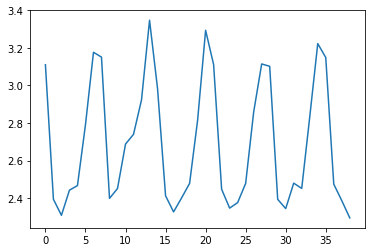

In [26]:
plt.plot(testpreds[129])

In [27]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [28]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              2.347560   
air_0164b9927d20bcc3_2017-04-23              1.627680   
air_0241aa3964b7f861_2017-04-23              2.316970   
air_0328696196e46f18_2017-04-23              2.036740   
air_034a3d5b40d5b1b1_2017-04-23              3.410414   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   9.460018  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   4.092049  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   9.144885  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   6.665580  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  29.277791

In [29]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [30]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [31]:
submission.to_csv("../submission/3001eb_lgb_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')